In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse, aic
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
import math
from datetime import datetime
import itertools
import os
import io

In [2]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Load data

In [4]:
df = pd.read_excel("Total 2018-2022.xlsx")

# Data preprocessing

## Check for missing values

In [6]:
df.isna().sum().sum()

np.int64(0)

In [7]:
df.isnull().sum().sum()

np.int64(0)

## Translate columns from Greek to English

In [8]:
df = df.rename(columns={
    'Χρονική περίοδος': 'Date',
    'Ενοξαπαρίνη': 'Enoxaparin',
    'Τινζαπαρίνη': 'Tinzaparin',
    'Ηπαρίνη': 'Heparin',
    'Δαλτεπαρίνη': 'Dalteparin',
    'Ναδροπαρίνη': 'Nadroparin',
    'Παρναπαρίνη': 'Parnaparin',
    'Βεμηπαρίνη': 'Bemiparin',
    'Φονταπαρινόξη': 'Fondaparinux',
    'Ετ. Δαβιγατράνη': 'Dabigatran etexilate',
    'Ριβαροξαμπάνη': 'Rivaroxaban',
    'Απιξαμπάνη': 'Apixaban',
    'Βαρφαρίνη': 'Warfarin',
    'Ασενοκουμαρόλη': 'Acenocoumarol'
})

## Make sure first column is a 'date' column

In [9]:
# Give it format year-month-day (default: 1st day of the month)
df['Date'] = pd.to_datetime(df['Date'], format='%m/%Y')
# Set Date as index
df.set_index('Date', inplace=True)
# Sort index to ensure chronological order
df.sort_index(inplace=True)

## Create a total column (sum of all drugs)

In [10]:
df['Total'] = df.sum(axis=1)

# Exploratory Data Analysis

## Plot time series

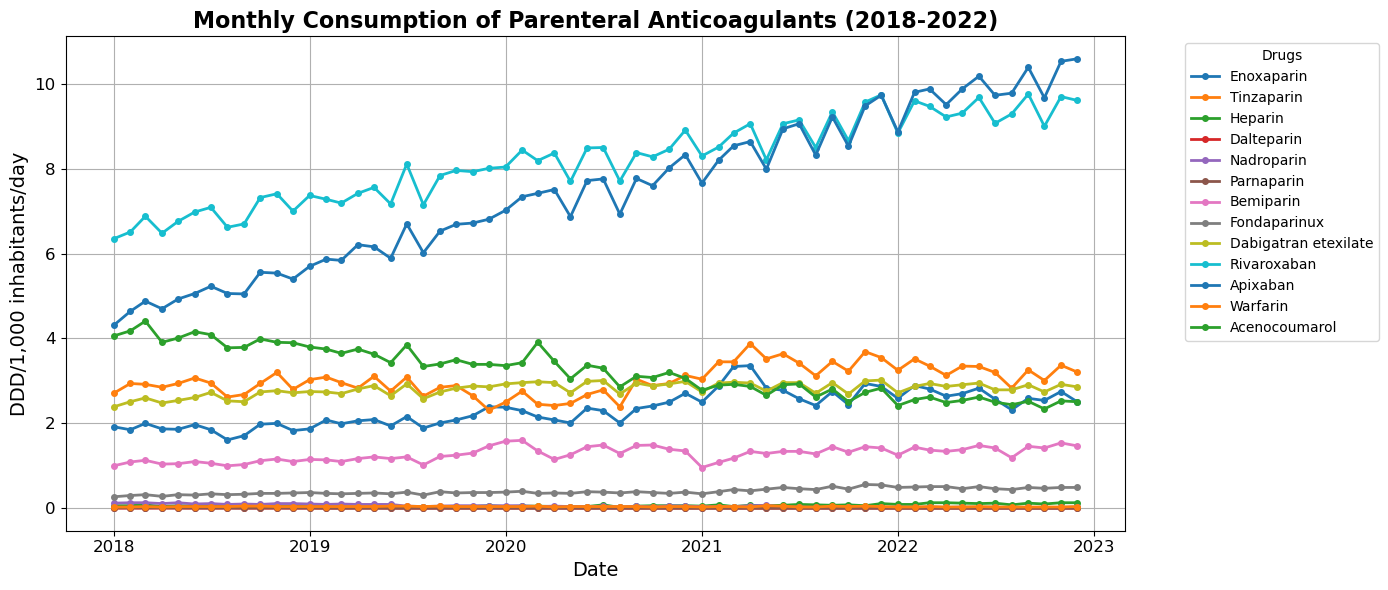

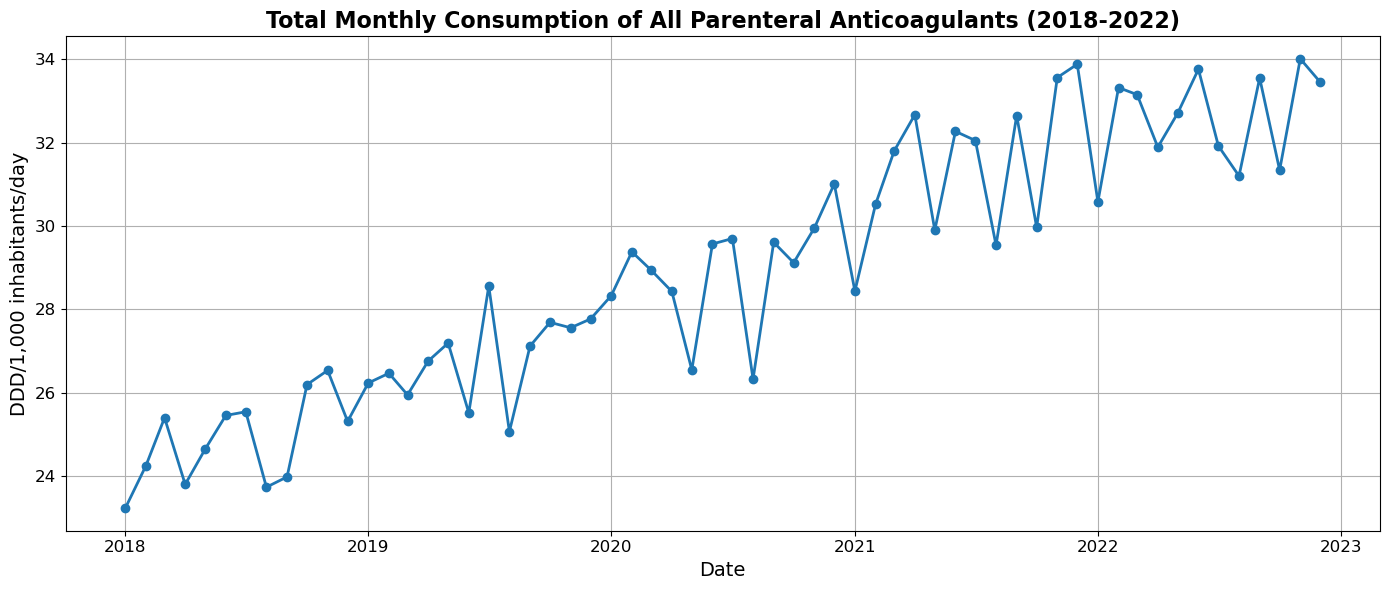

In [12]:
# Plot individual drugs
plt.figure(figsize=(14, 6))
for column in df.columns:
    if column != 'Total':
        plt.plot(df.index, df[column], label=column, linewidth = 2, marker = 'o', markersize=4)
plt.title('Monthly Consumption of Parenteral Anticoagulants (2018-2022)', fontsize=16, fontweight="bold")
plt.xlabel('Date', fontsize=14)
plt.ylabel('DDD/1,000 inhabitants/day', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Drugs', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot total consumption
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Total'], linewidth=2, marker='o')
plt.title('Total Monthly Consumption of All Parenteral Anticoagulants (2018-2022)', fontsize=16, fontweight="bold")
plt.xlabel('Date', fontsize=14)
plt.ylabel('DDD/1,000 inhabitants/day', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

## Market share

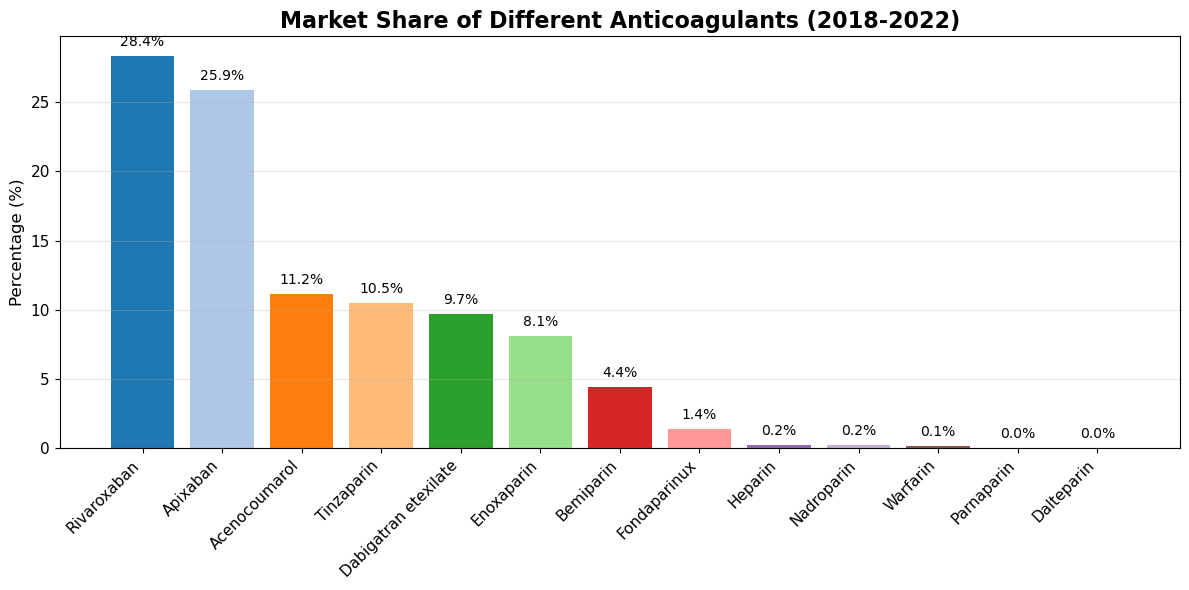

In [13]:
## calculate market share
market_share = df.drop("Total", axis=1).mean() / df.drop("Total", axis=1).mean().sum() * 100
market_share = market_share.sort_values(ascending=False)

## plot
plt.figure(figsize=(12, 6))
bars = plt.bar(market_share.index, market_share.values, color=plt.cm.tab20.colors)
# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.1f}%', 
             ha='center', va='bottom', fontsize=10)

plt.title('Market Share of Different Anticoagulants (2018-2022)', fontsize=16, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

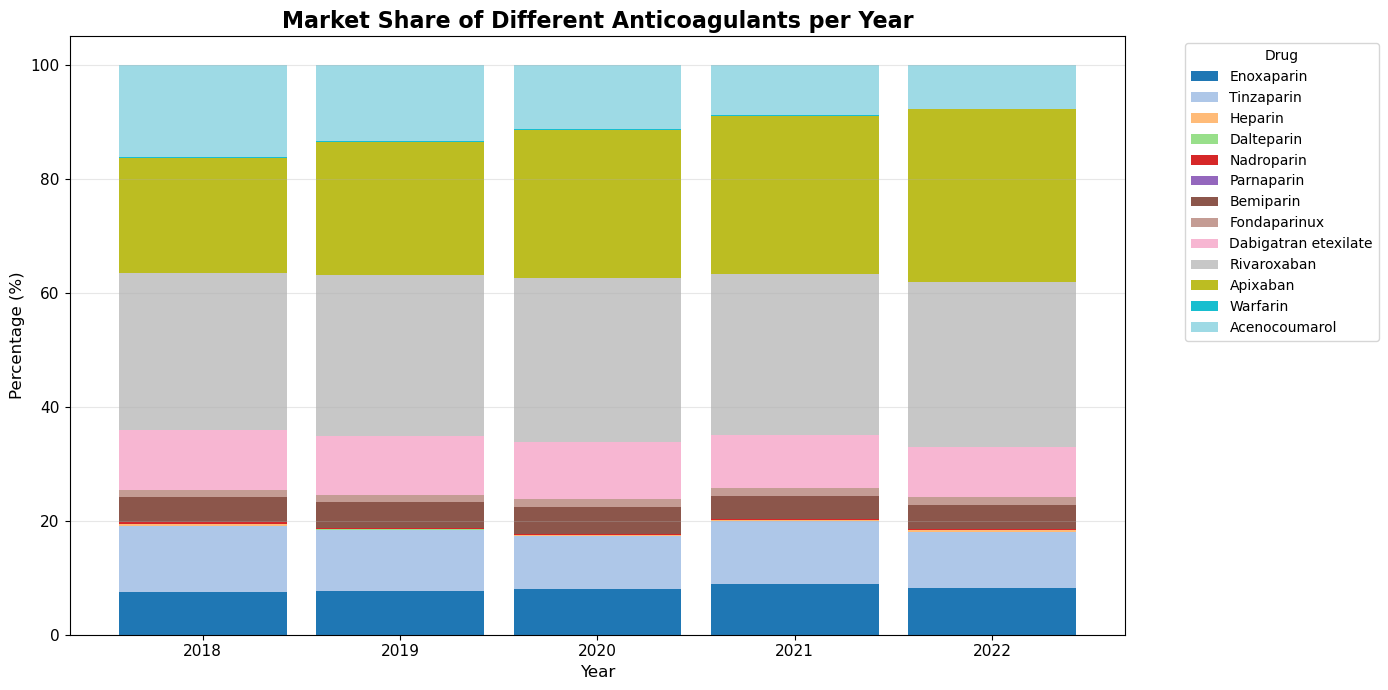

In [21]:
# Convert index to datetime
market_share2 = df.copy()
market_share2.index = pd.to_datetime(market_share2.index)

# Drop "Total"
market_share2 = market_share2.drop("Total", axis=1)

# Total drug consumption per year
market_share2 = market_share2.groupby(market_share2.index.year).sum()

# Compute market share per year
market_share_per_year2 = market_share2.div(market_share2.sum(axis=1), axis=0) * 100

# Plot stacked bar chart
plt.figure(figsize=(14, 7))
market_share_per_year2.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='tab20', width=0.85)

plt.title('Market Share of Different Anticoagulants per Year', fontsize=16, fontweight='bold')
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)
plt.legend(title='Drug', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Seasonality trends

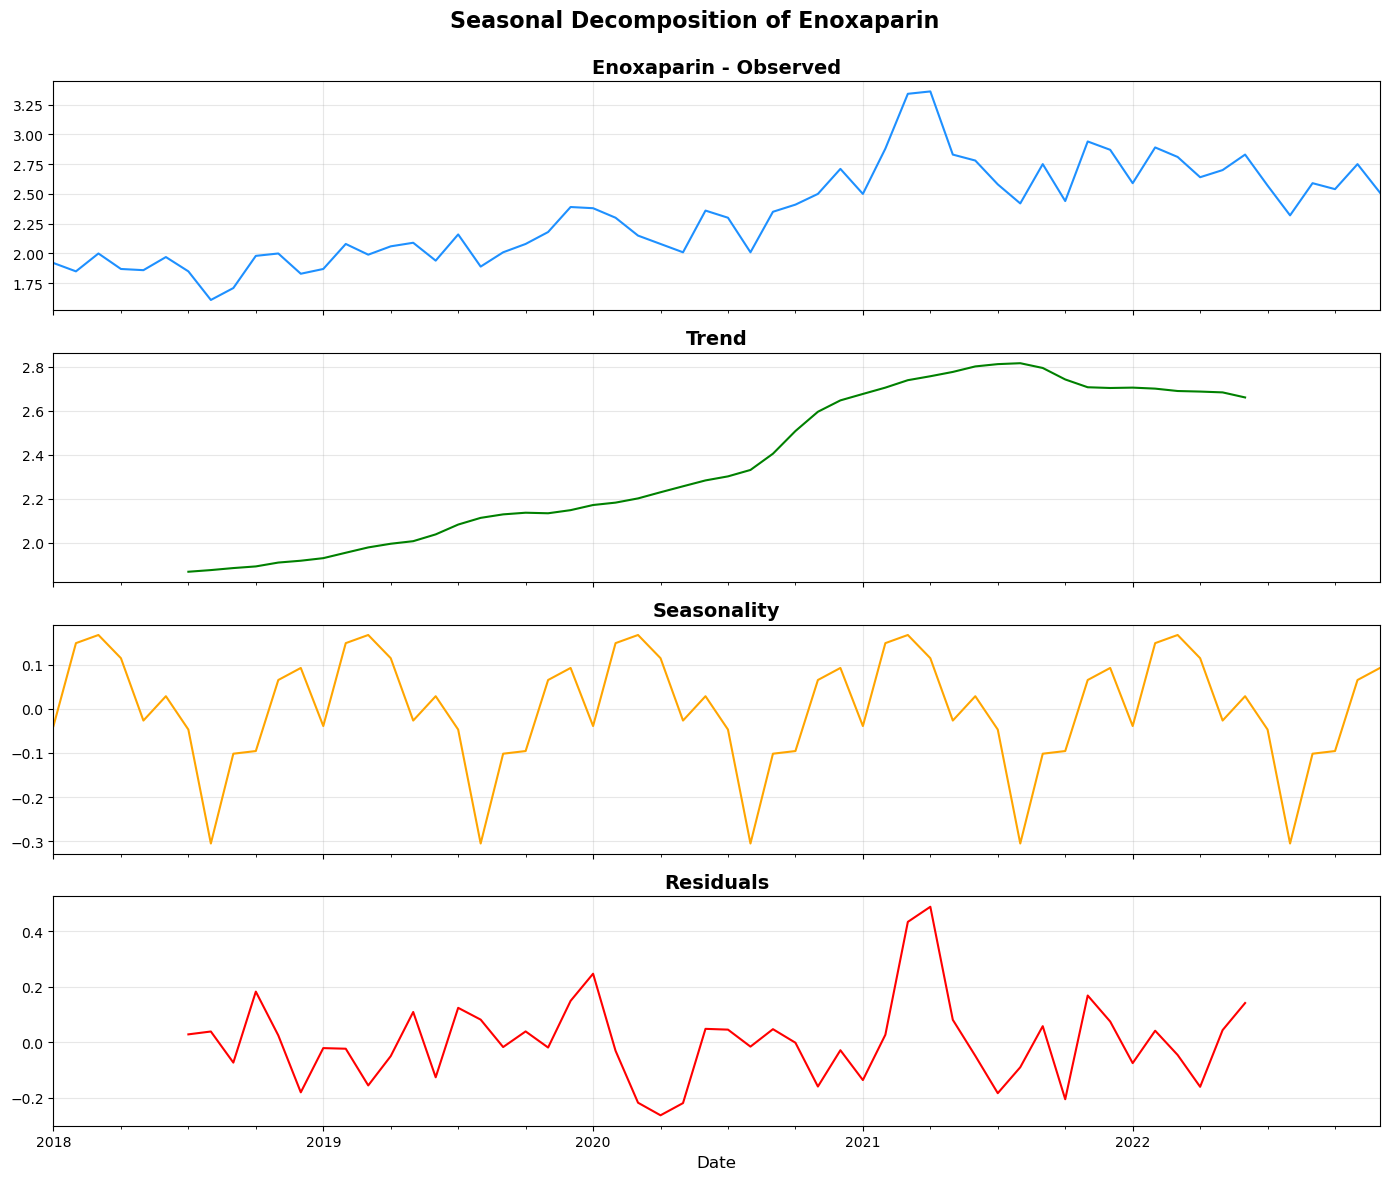

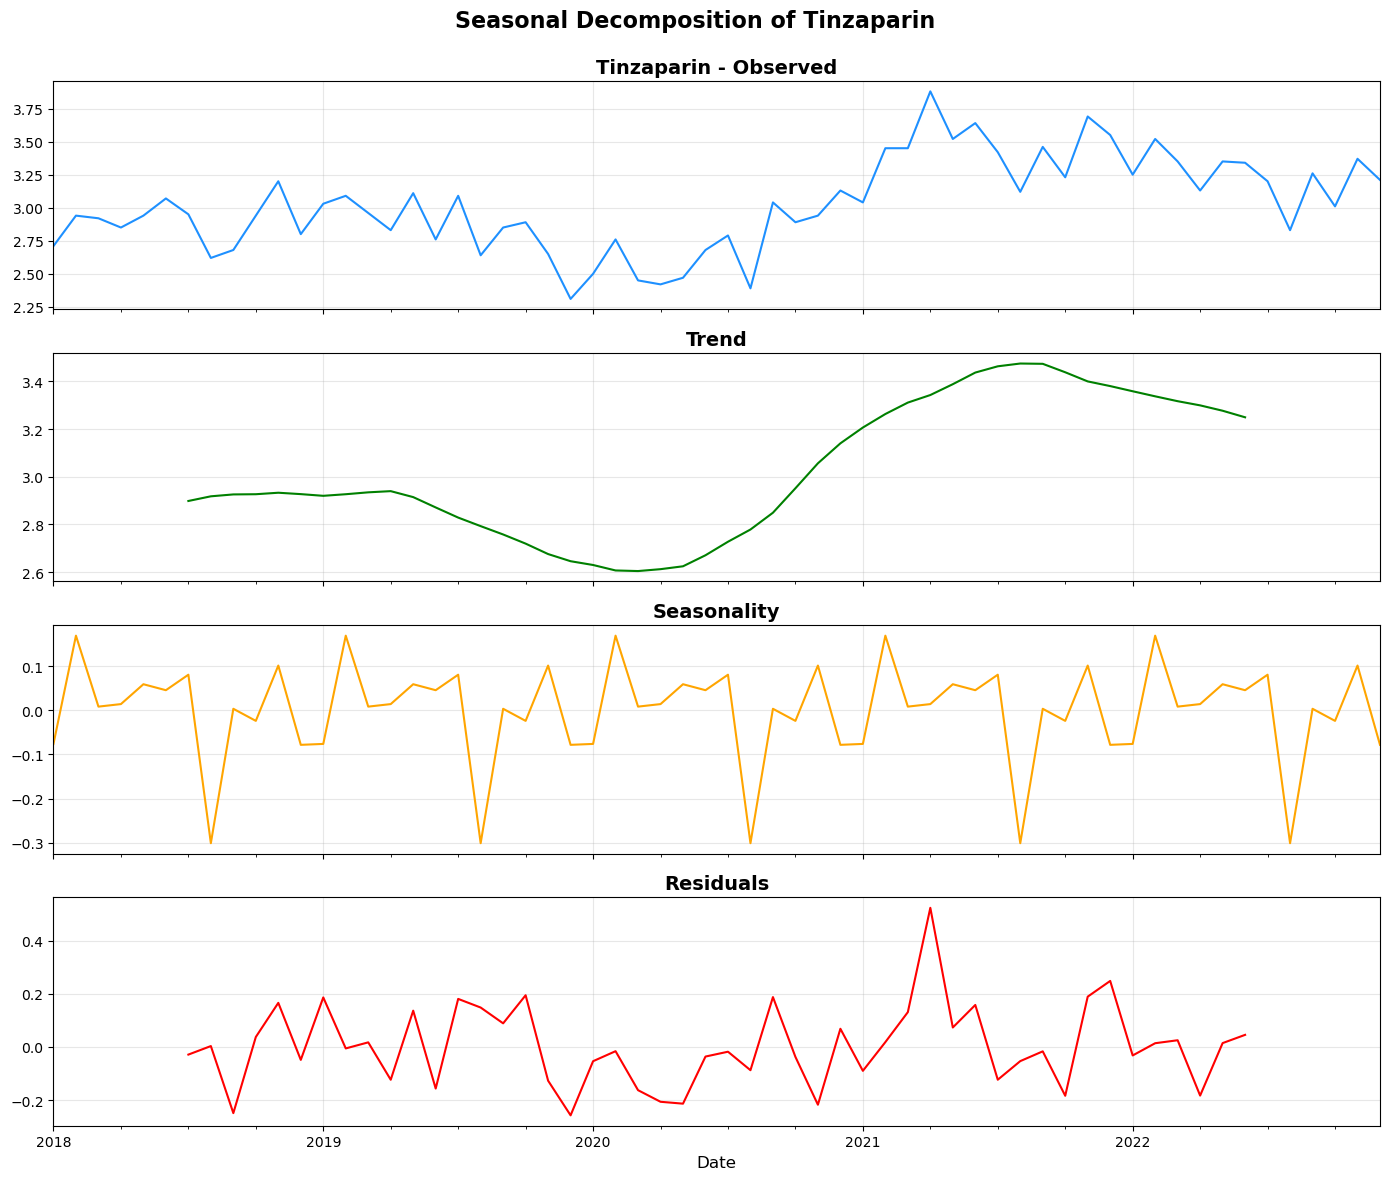

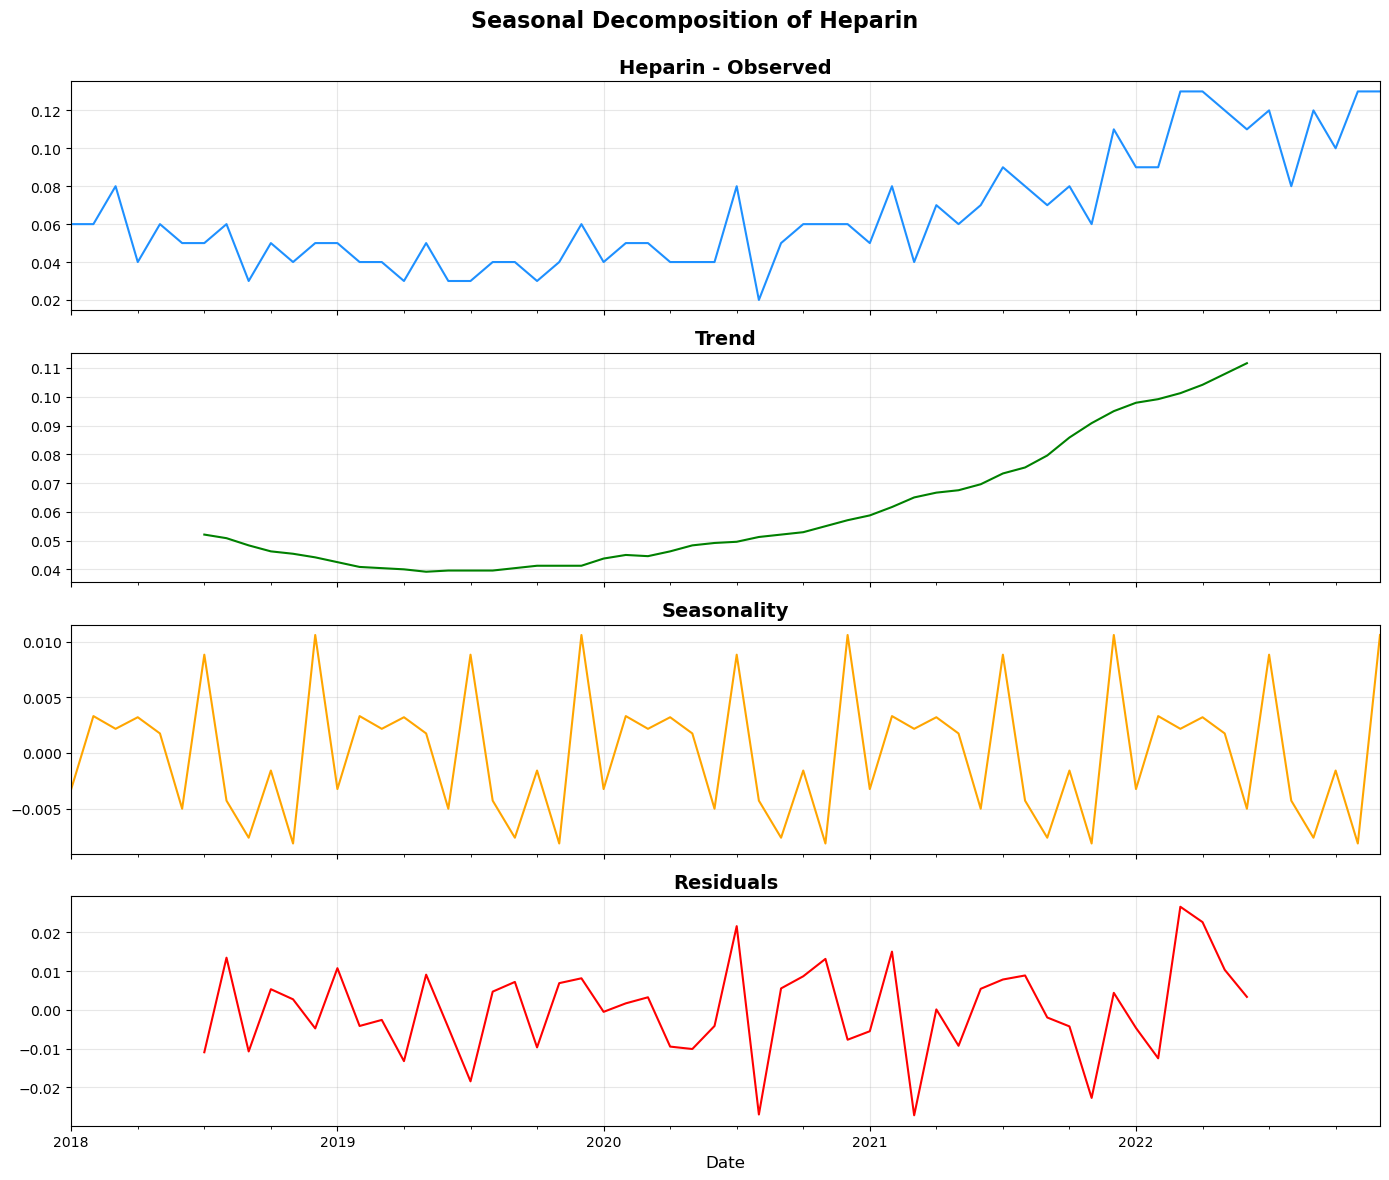

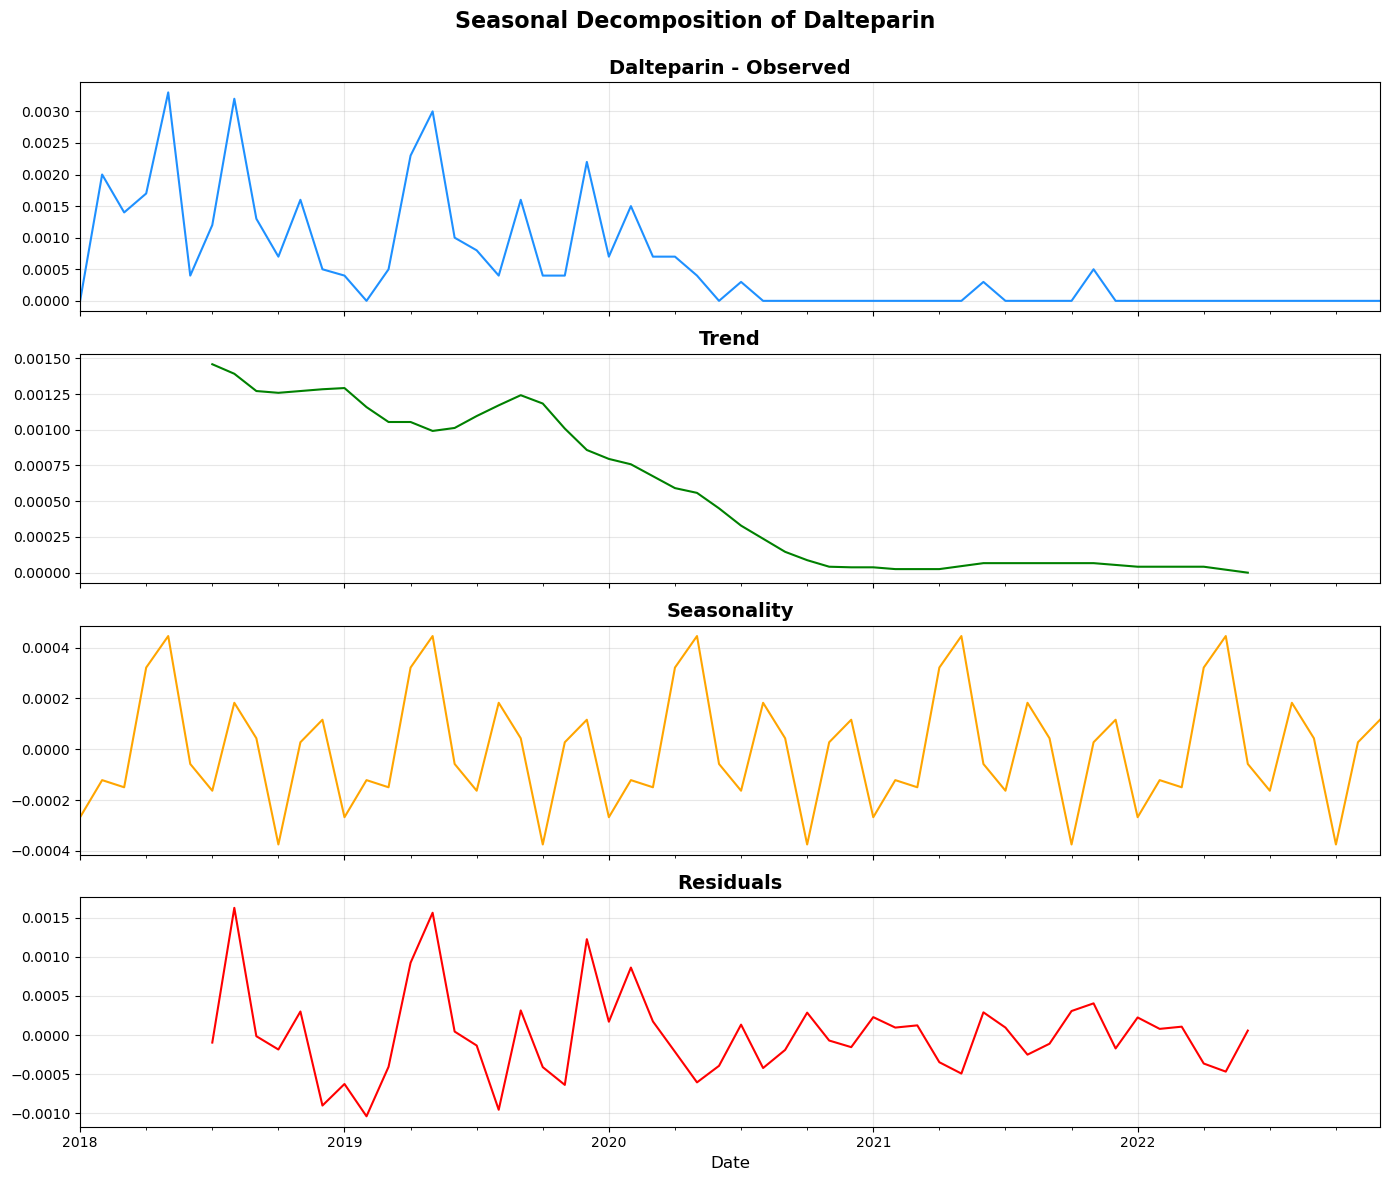

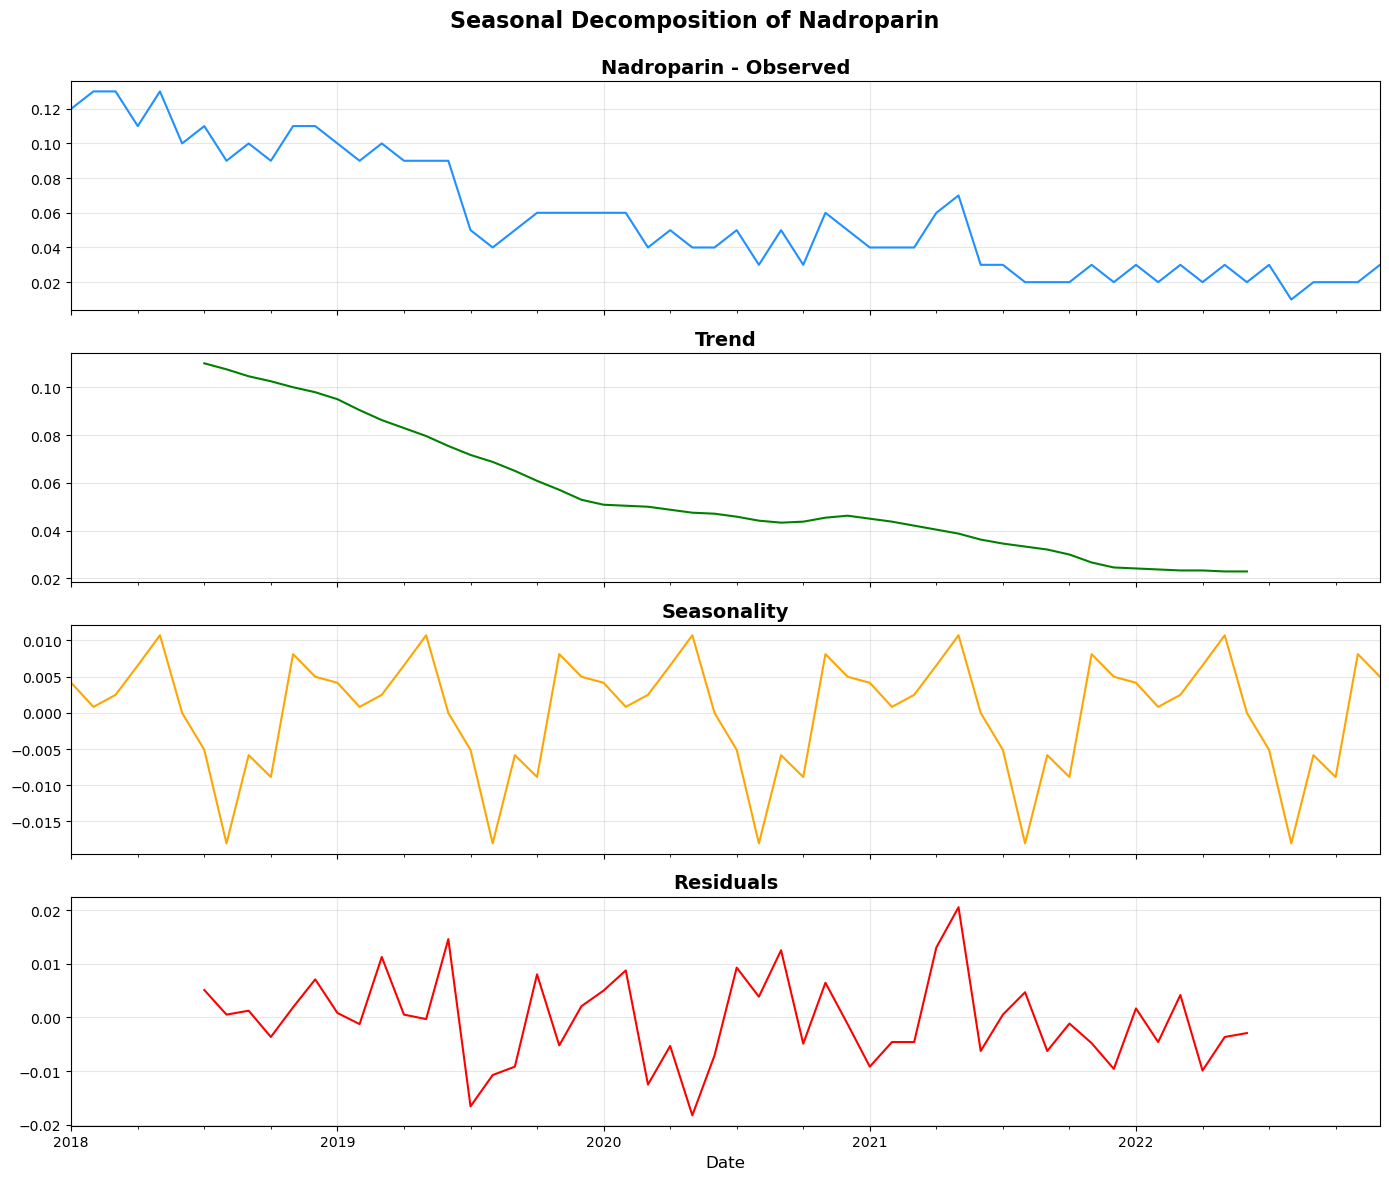

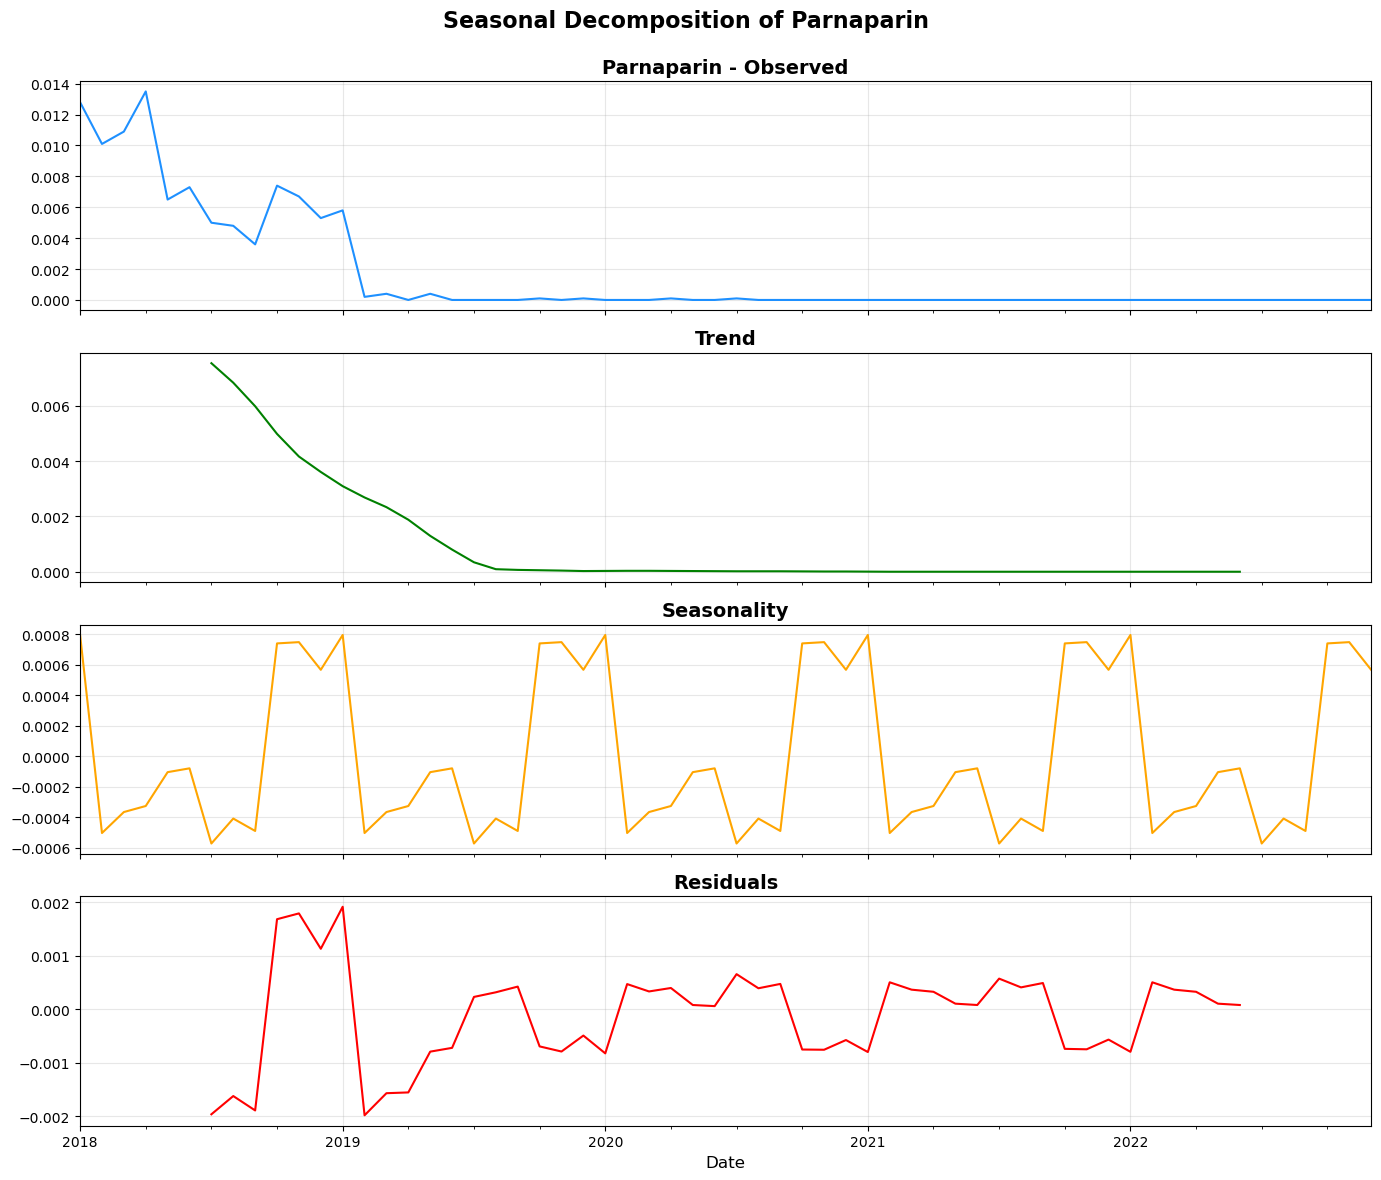

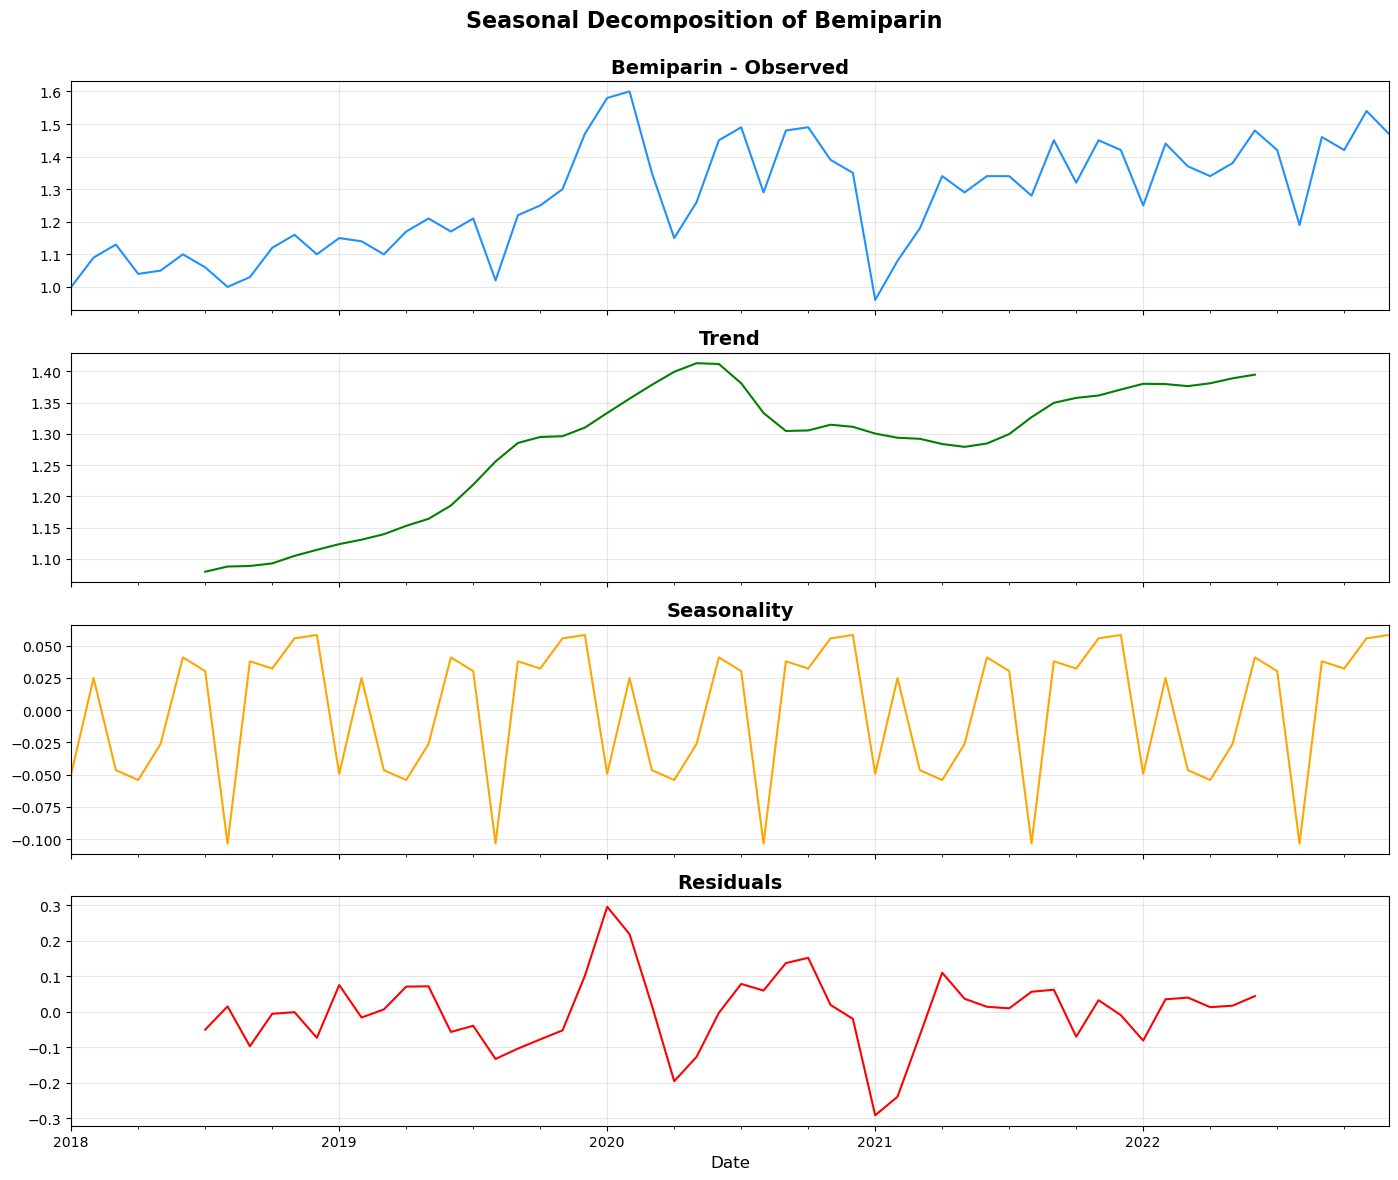

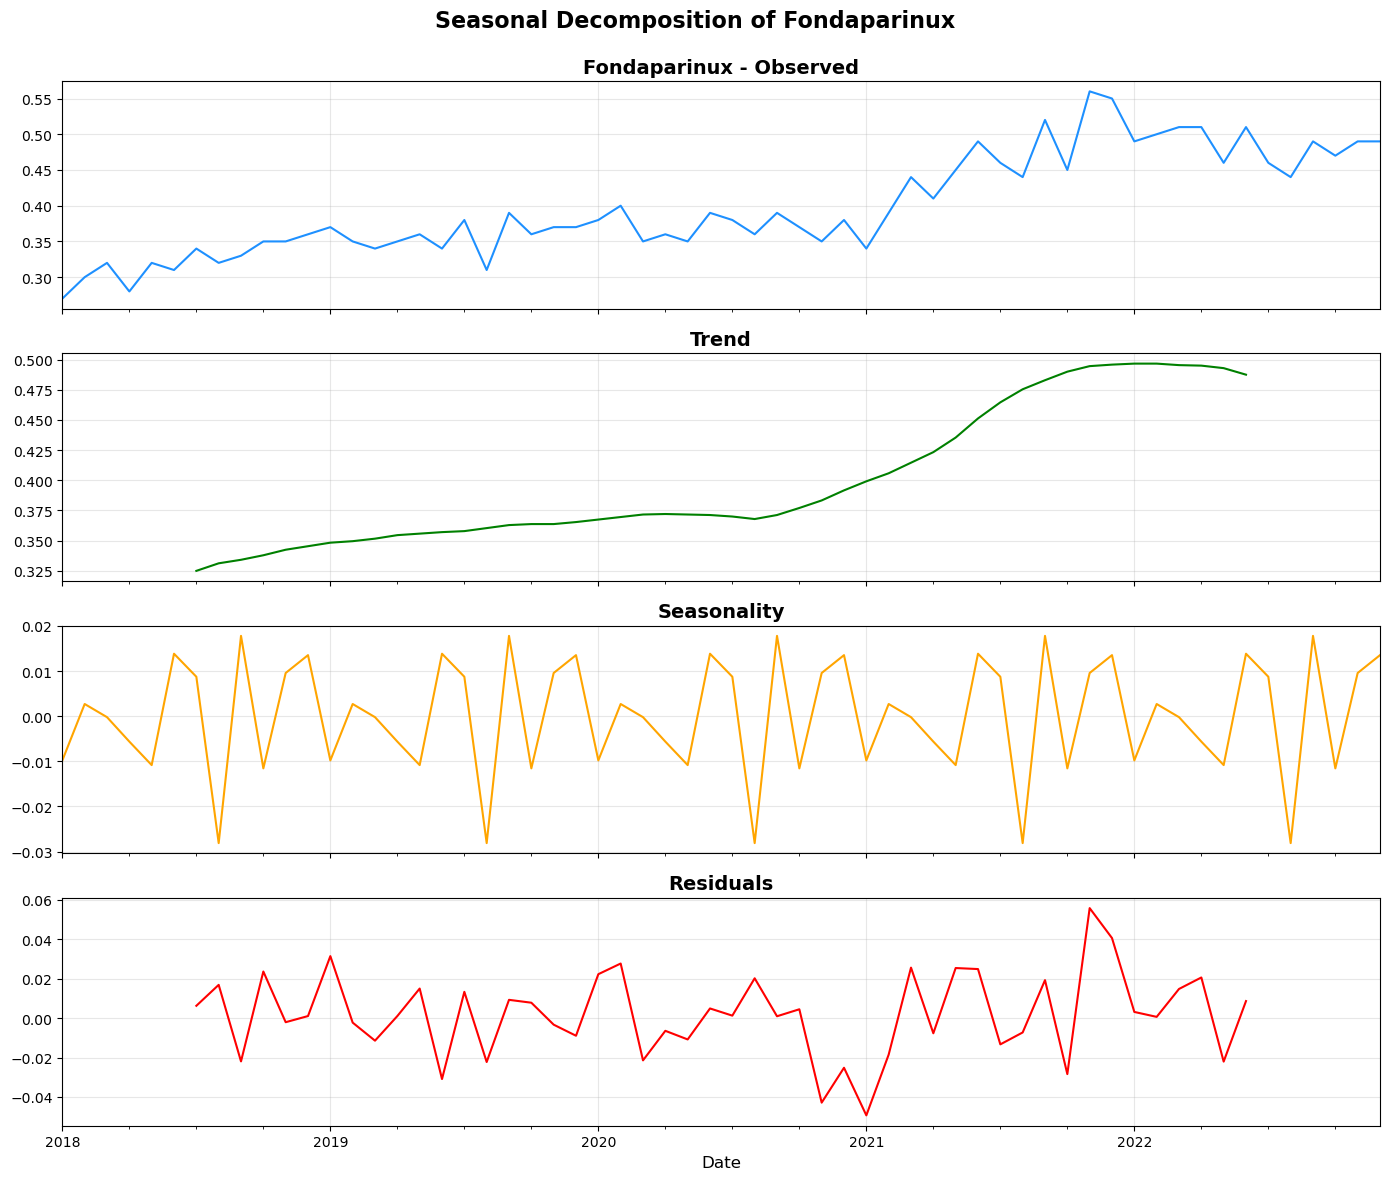

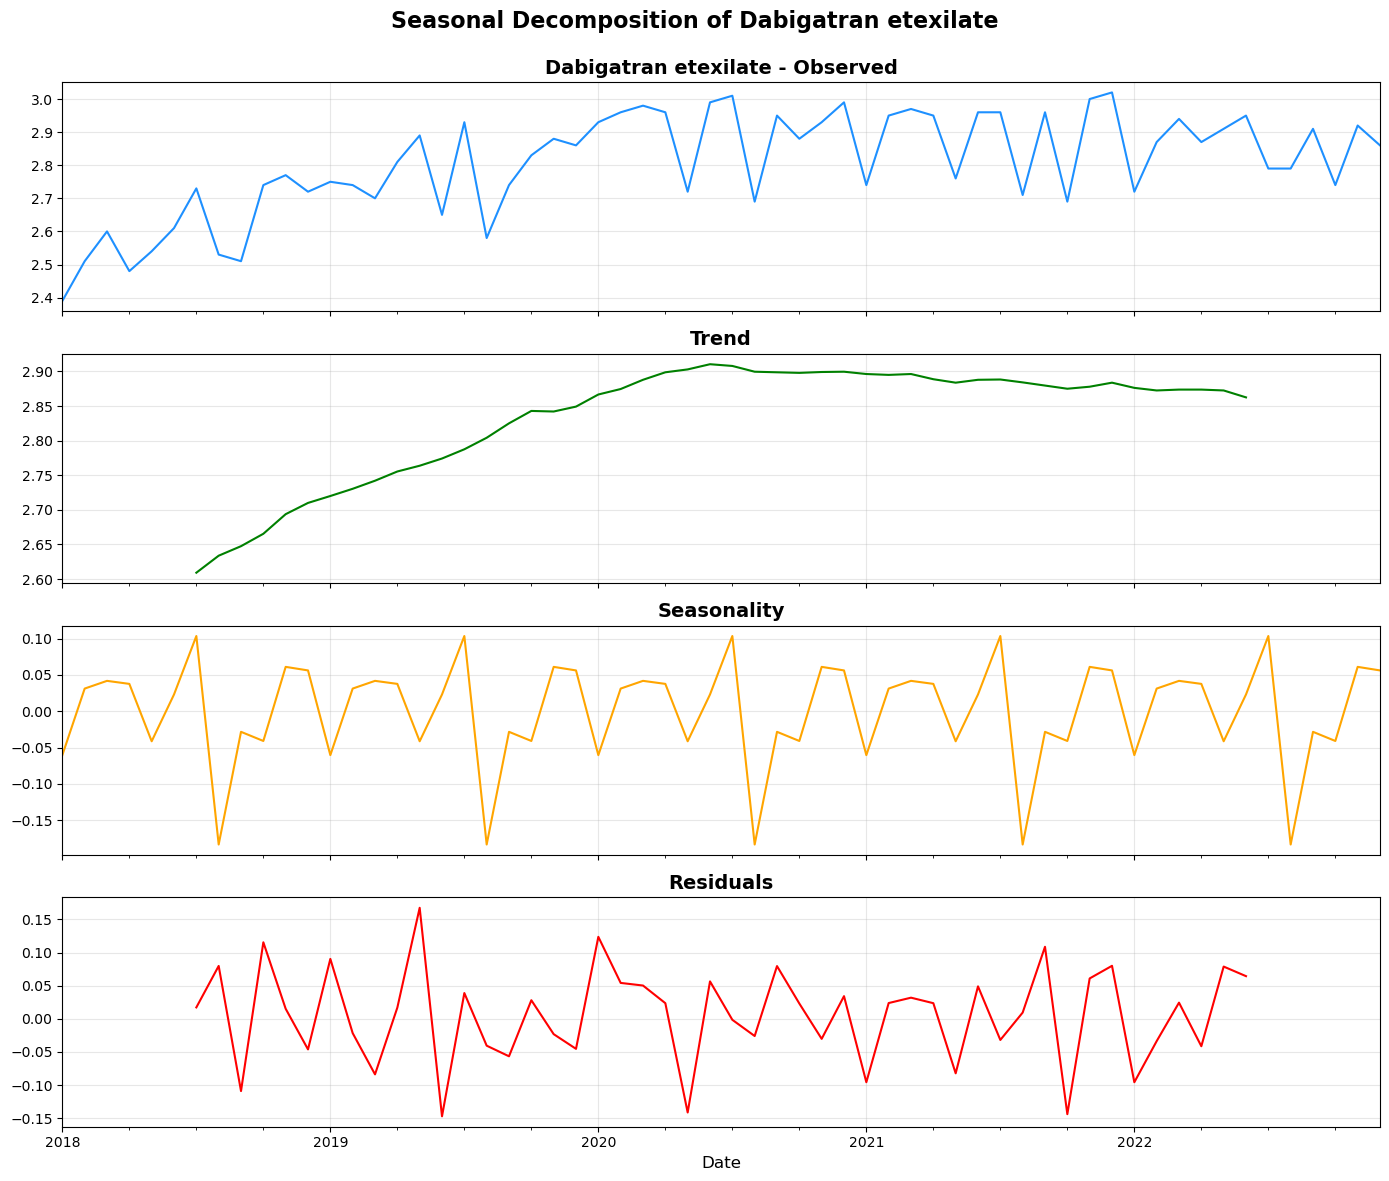

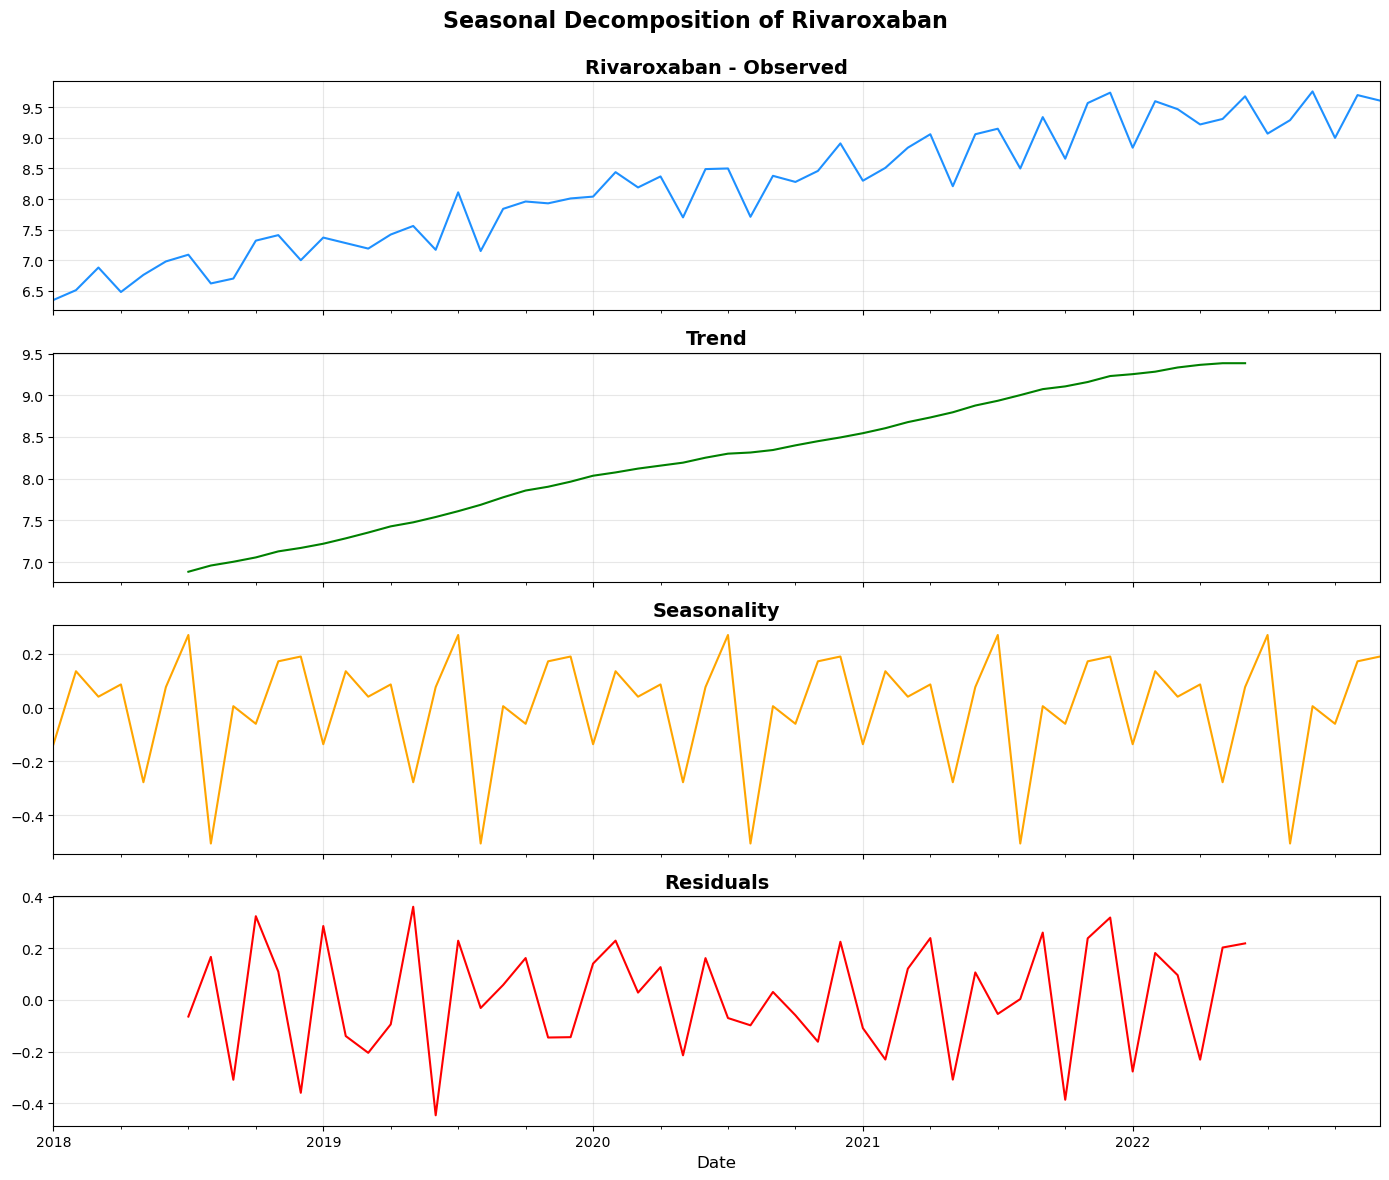

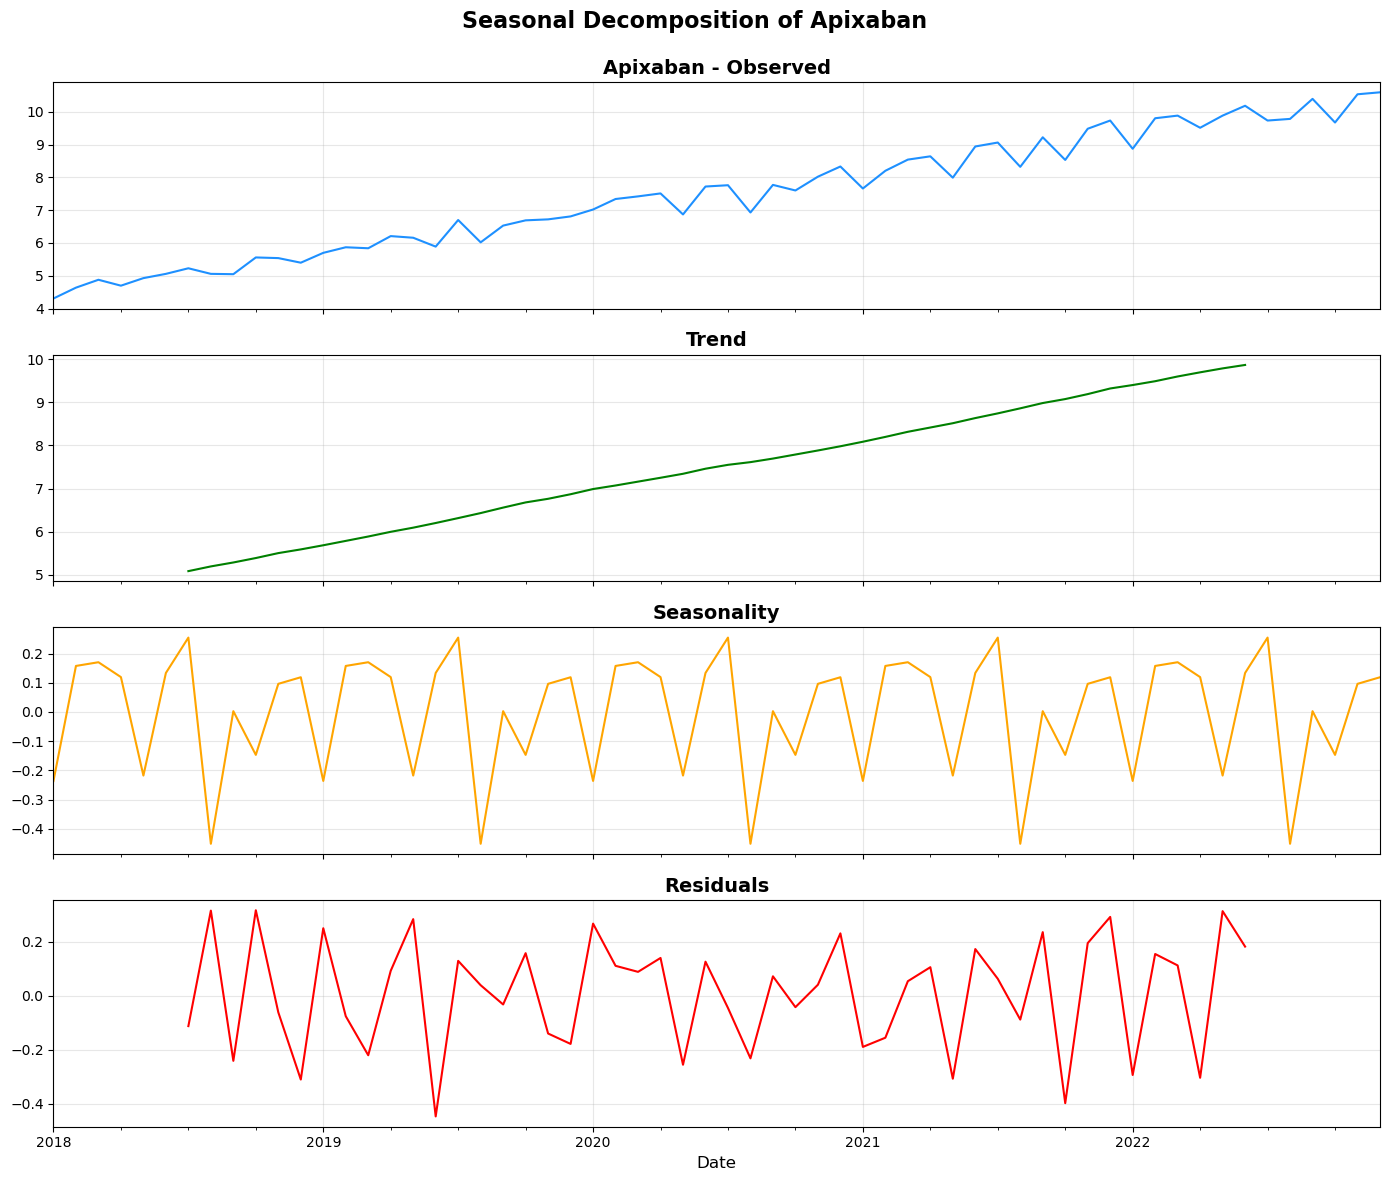

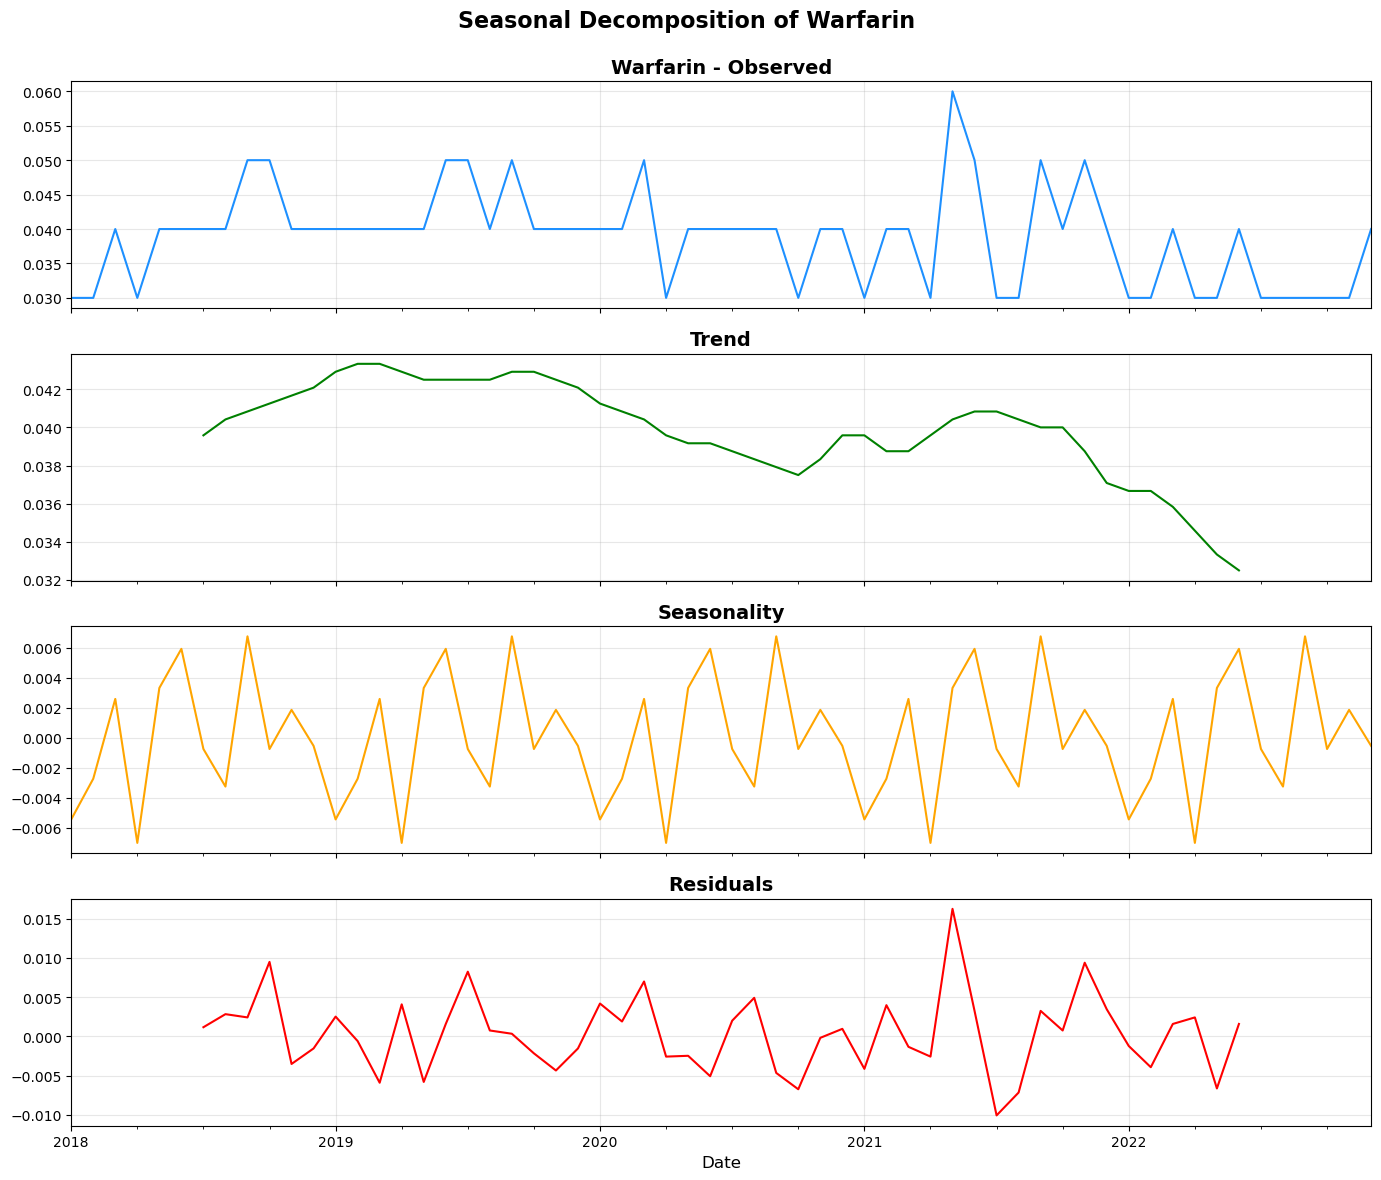

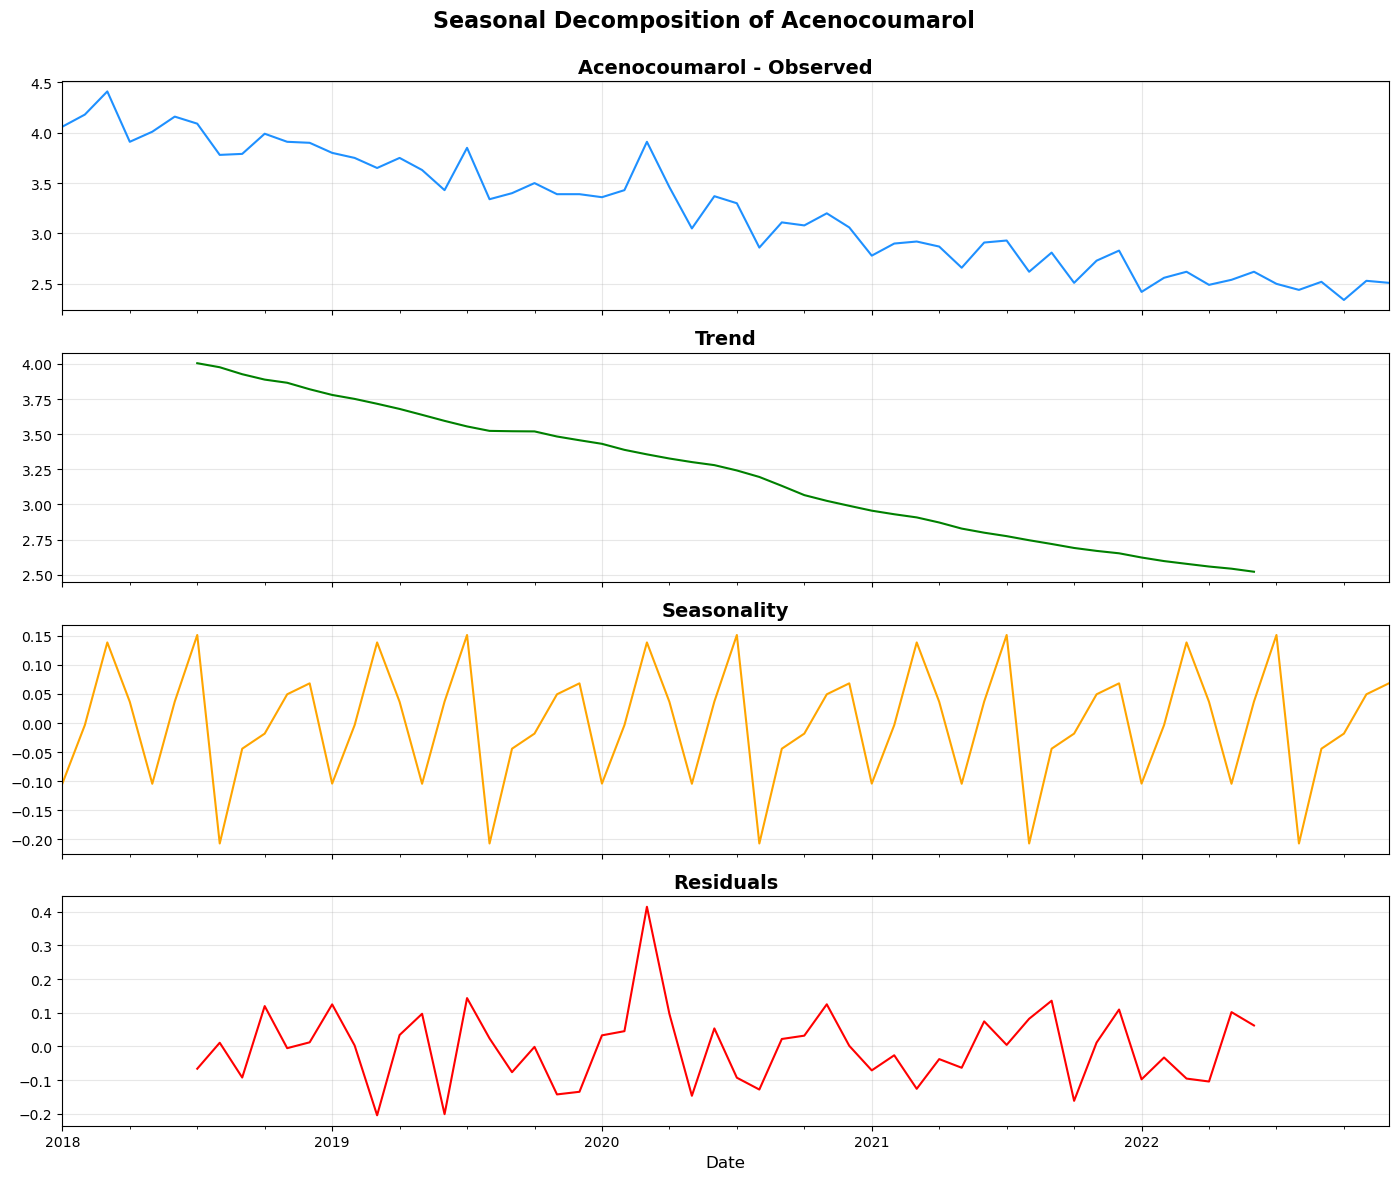

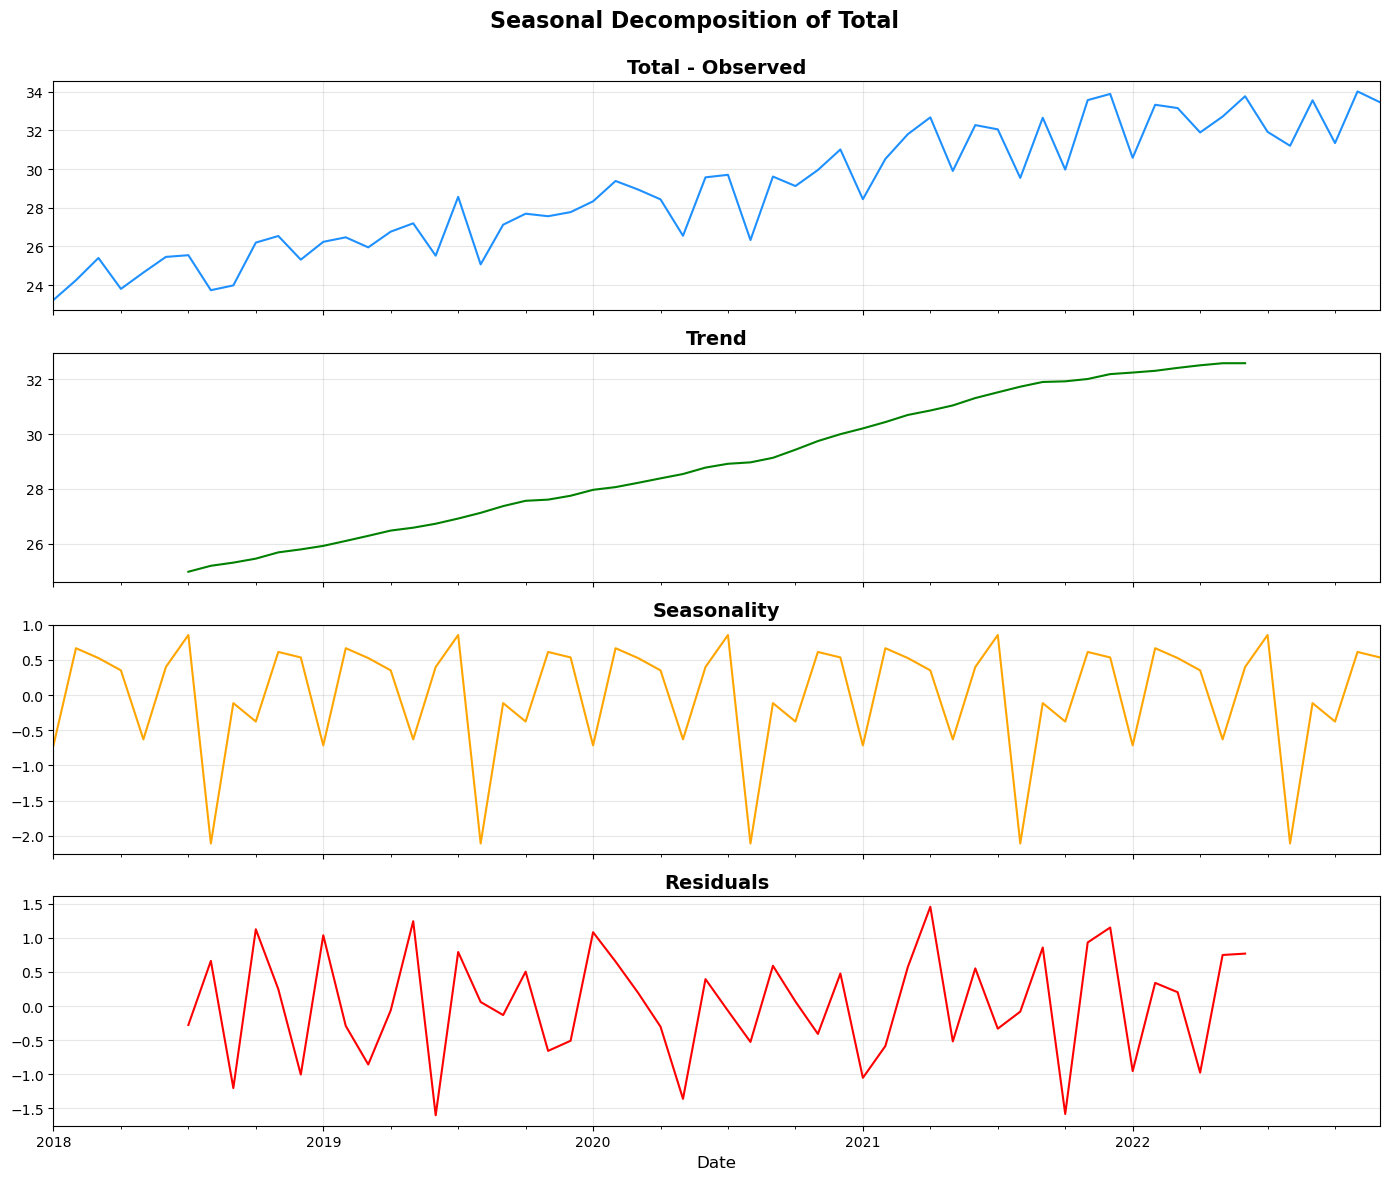

In [24]:
# Loop through each drug column except 'Total'
for column in df.columns:

    # Seasonal decomposition
    decomposition = seasonal_decompose(df[column], model='additive', period=12)

    # Create subplots
    fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

    # Observed
    decomposition.observed.plot(ax=axes[0], color='dodgerblue')
    axes[0].set_title(f'{column} - Observed', fontsize=14, fontweight='bold')
    axes[0].grid(alpha=0.3)

    # Trend
    decomposition.trend.plot(ax=axes[1], color='green')
    axes[1].set_title('Trend', fontsize=14, fontweight='bold')
    axes[1].grid(alpha=0.3)

    # Seasonal
    decomposition.seasonal.plot(ax=axes[2], color='orange')
    axes[2].set_title('Seasonality', fontsize=14, fontweight='bold')
    axes[2].grid(alpha=0.3)

    # Residuals
    decomposition.resid.plot(ax=axes[3], color='red')
    axes[3].set_title('Residuals', fontsize=14, fontweight='bold')
    axes[3].grid(alpha=0.3)

    # Common x-label
    axes[3].set_xlabel('Date', fontsize=12)

    # Overall title
    plt.suptitle(f'Seasonal Decomposition of {column}', fontsize=16, fontweight='bold')

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # leave space for suptitle

    plt.show()

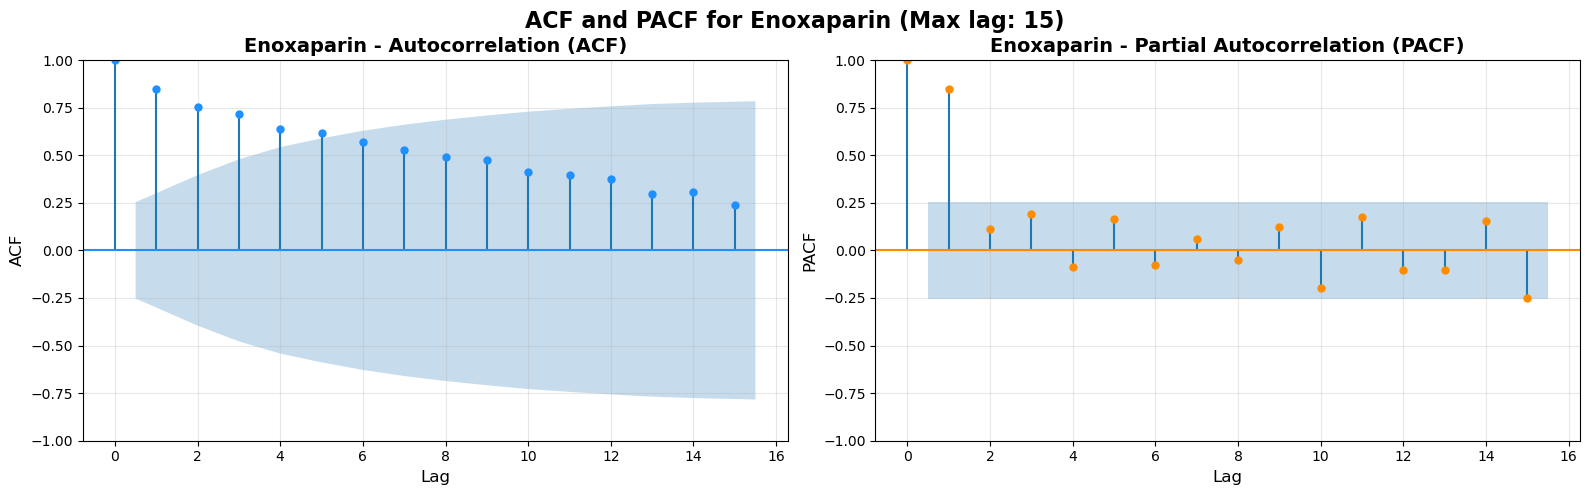

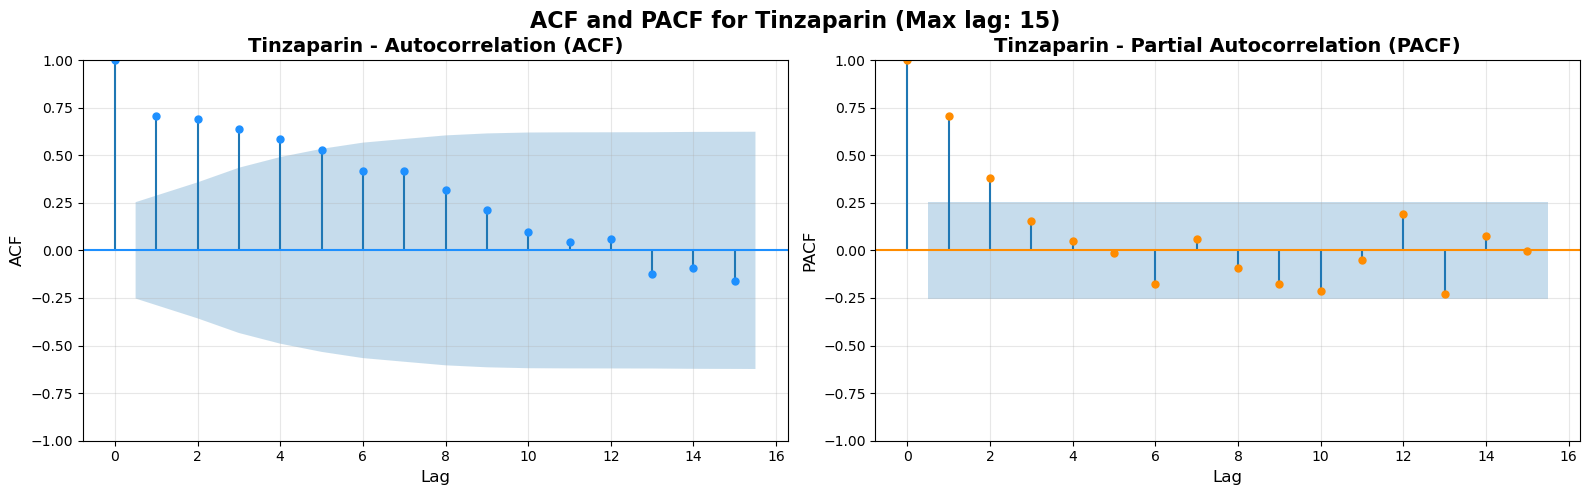

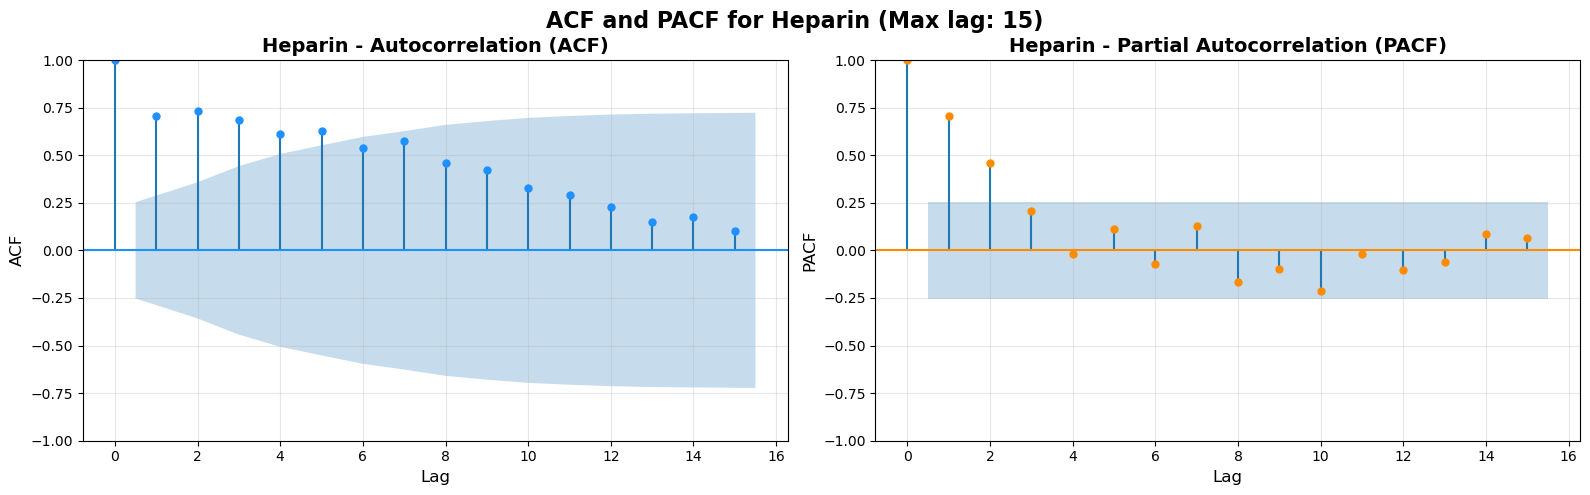

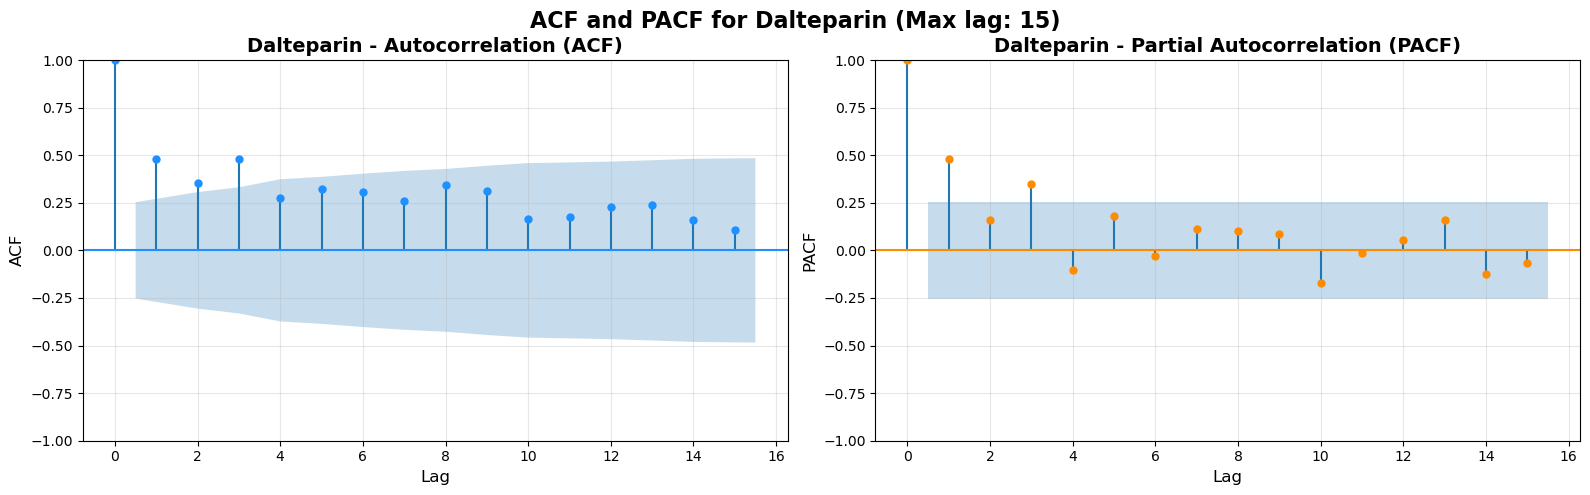

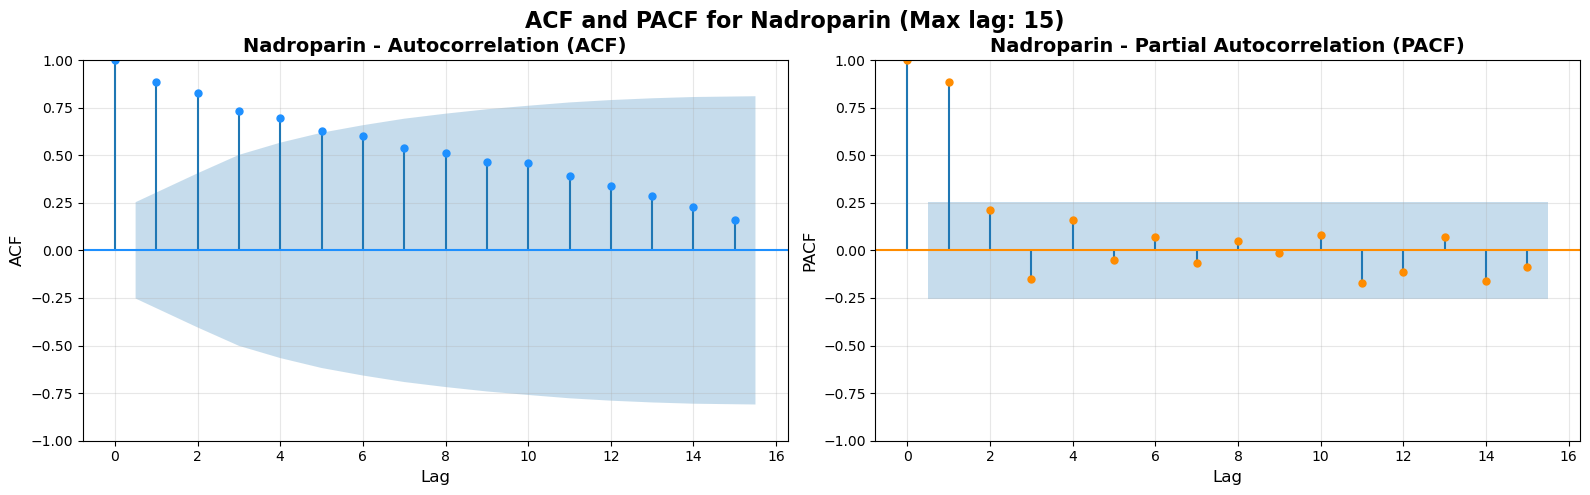

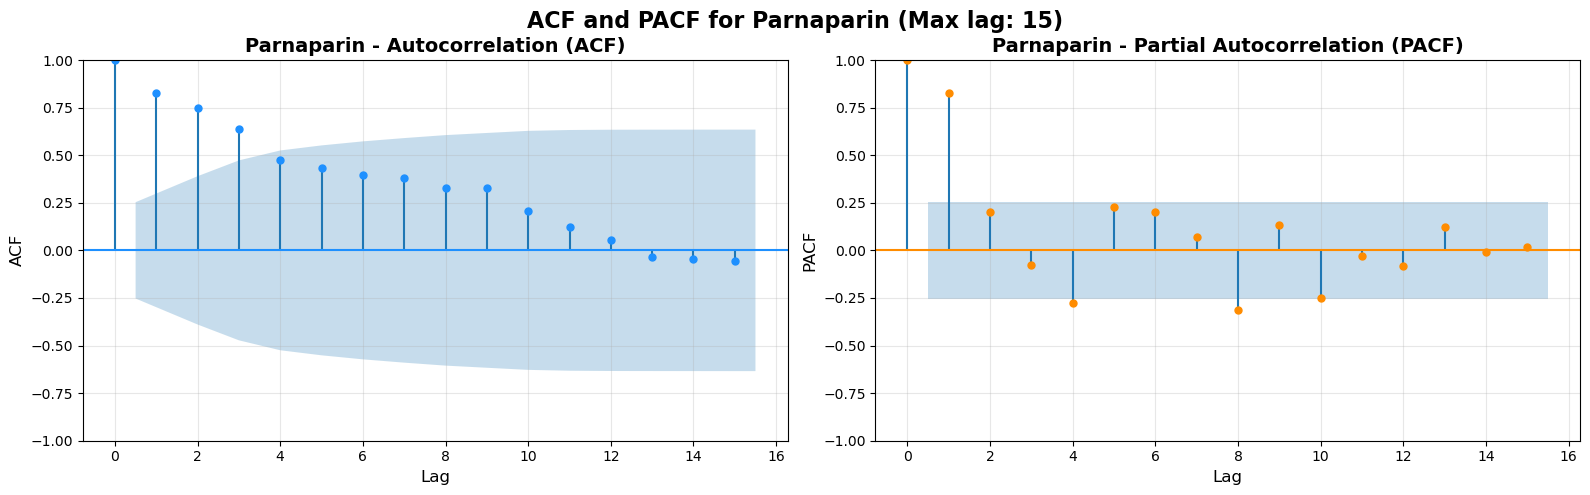

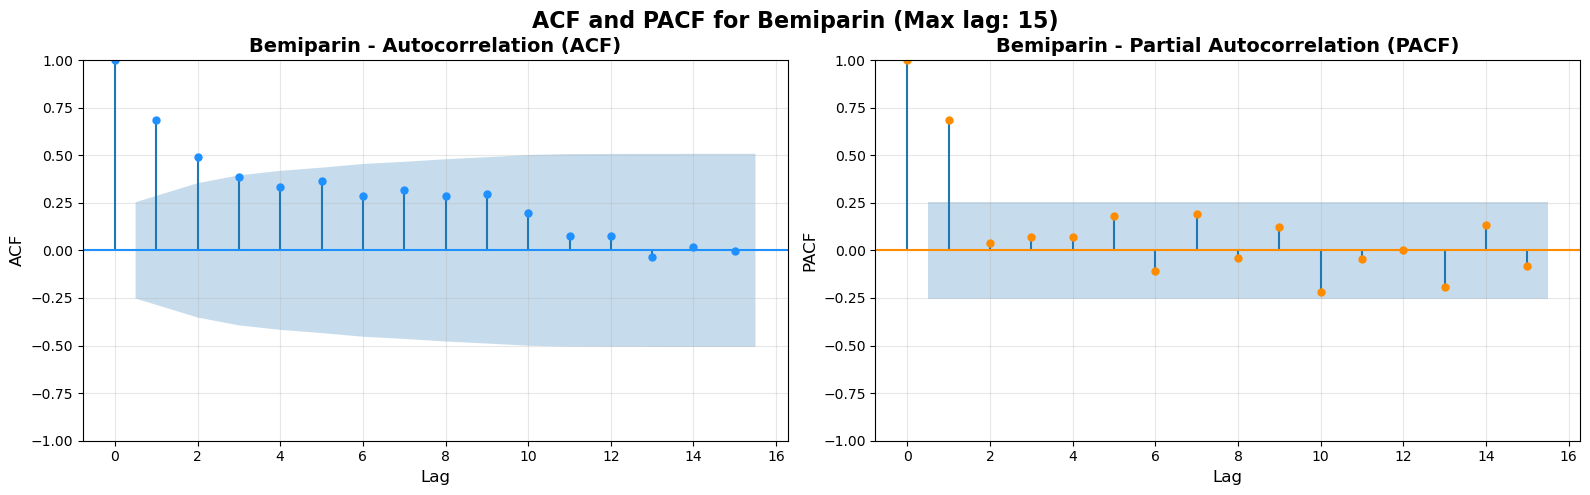

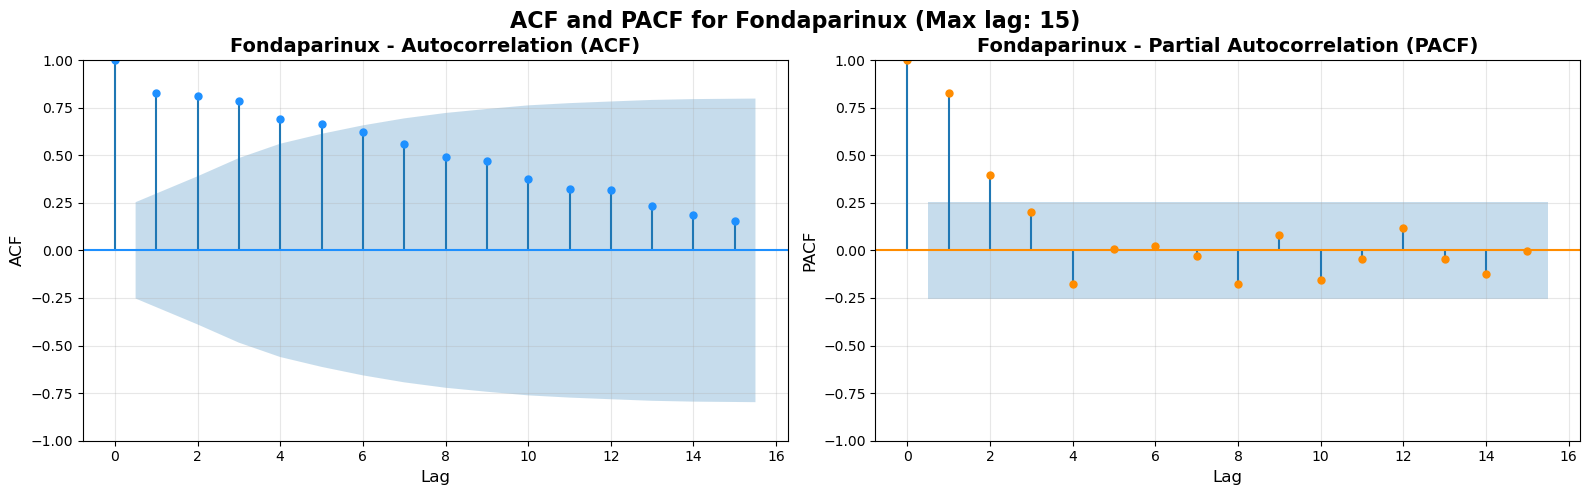

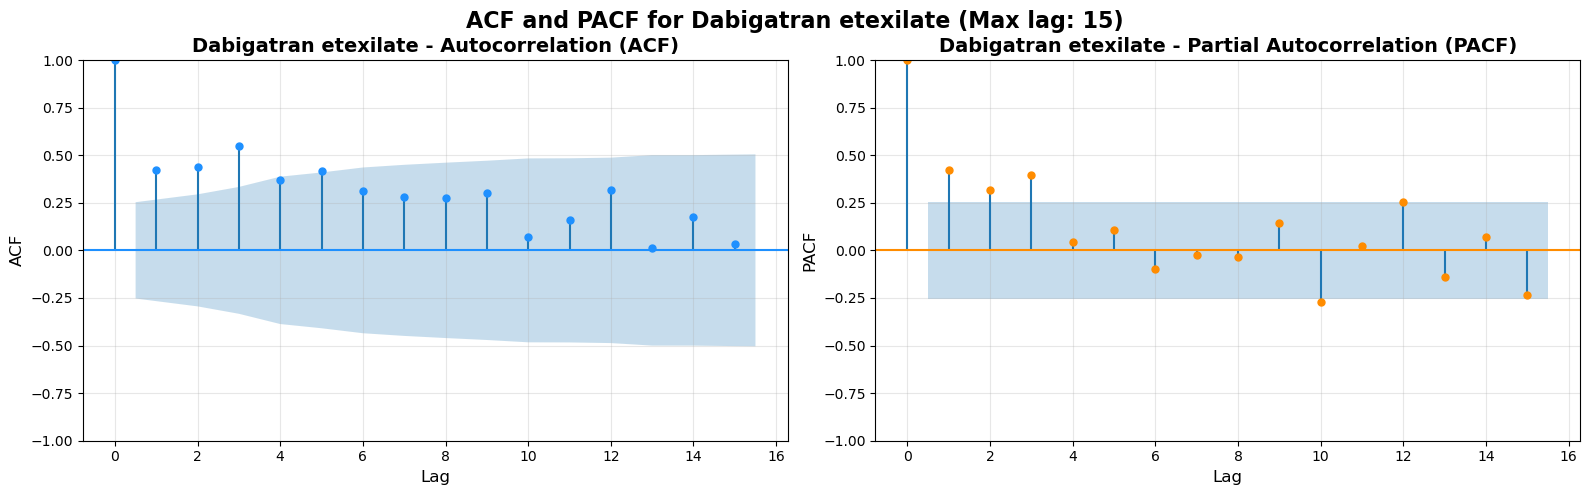

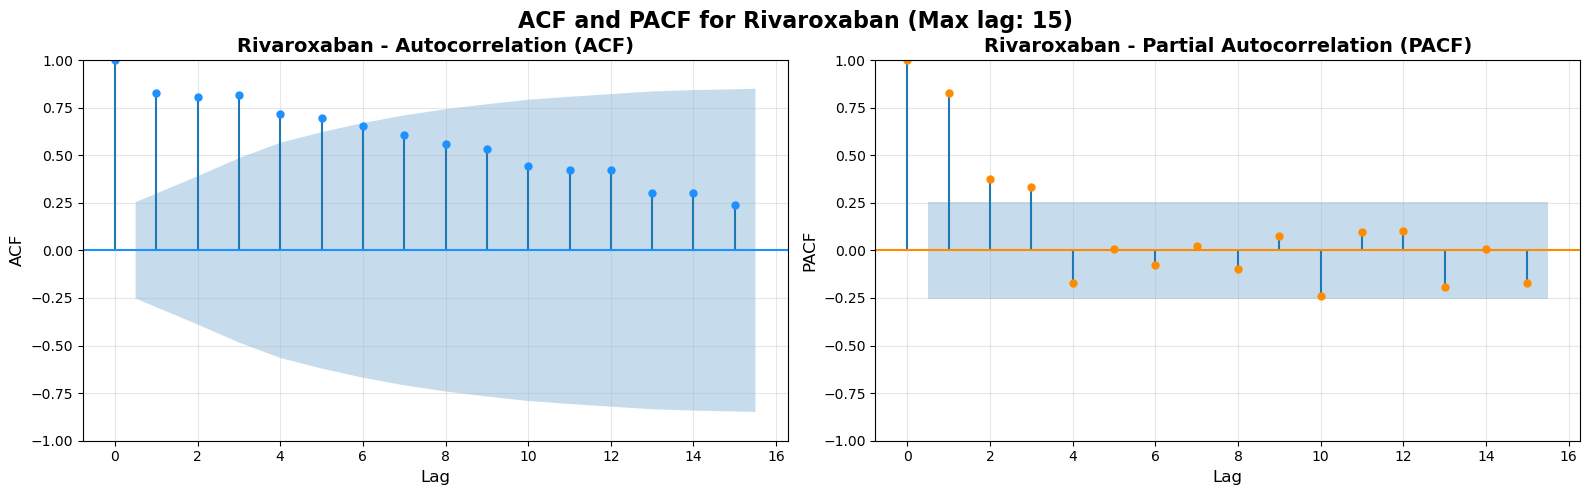

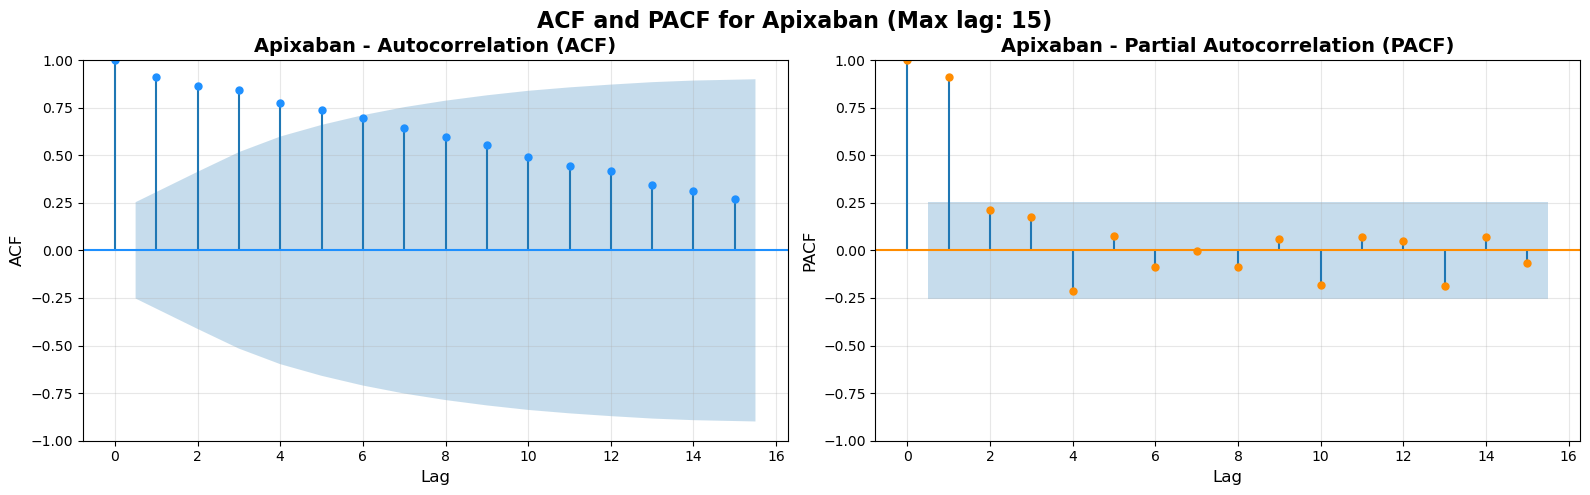

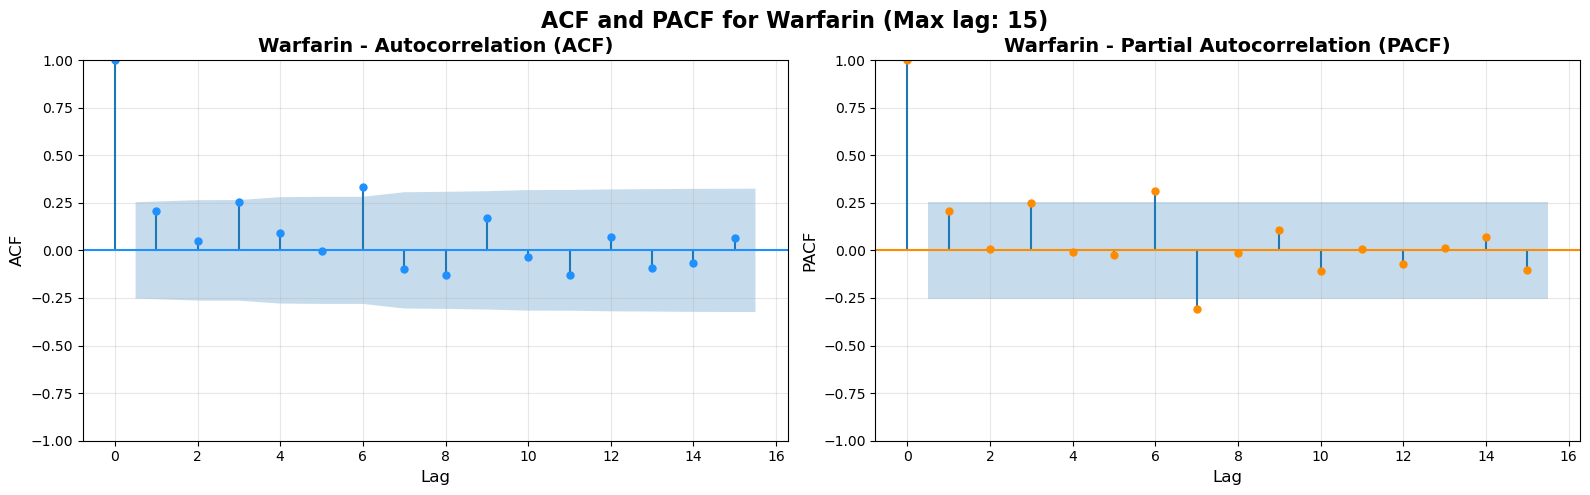

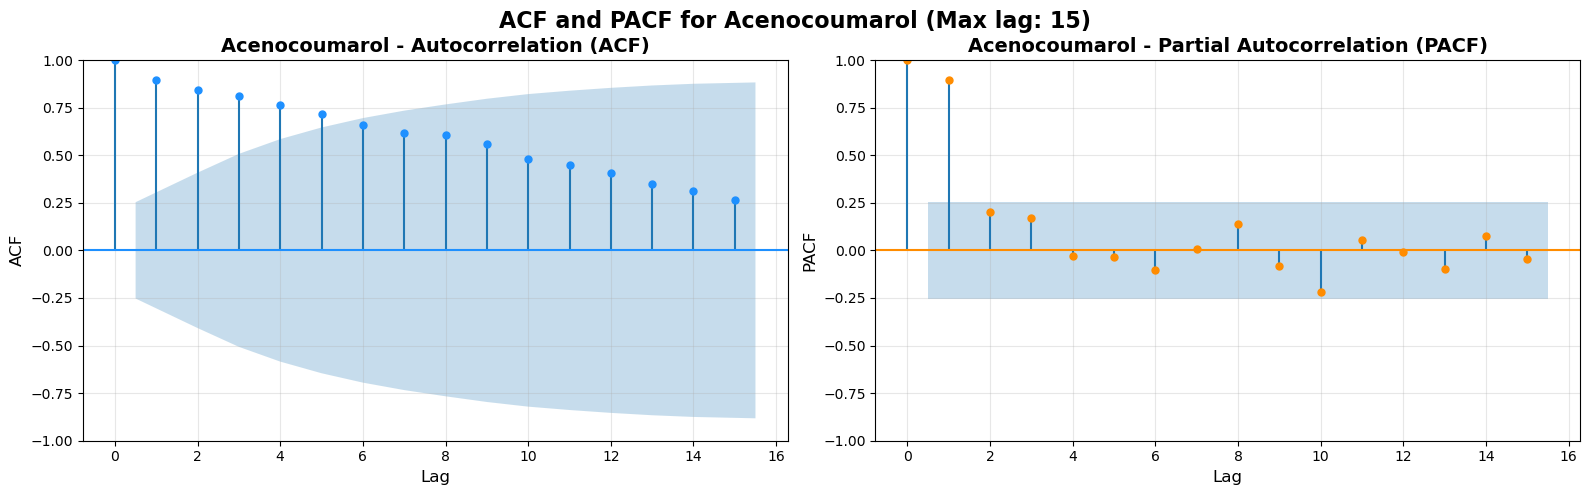

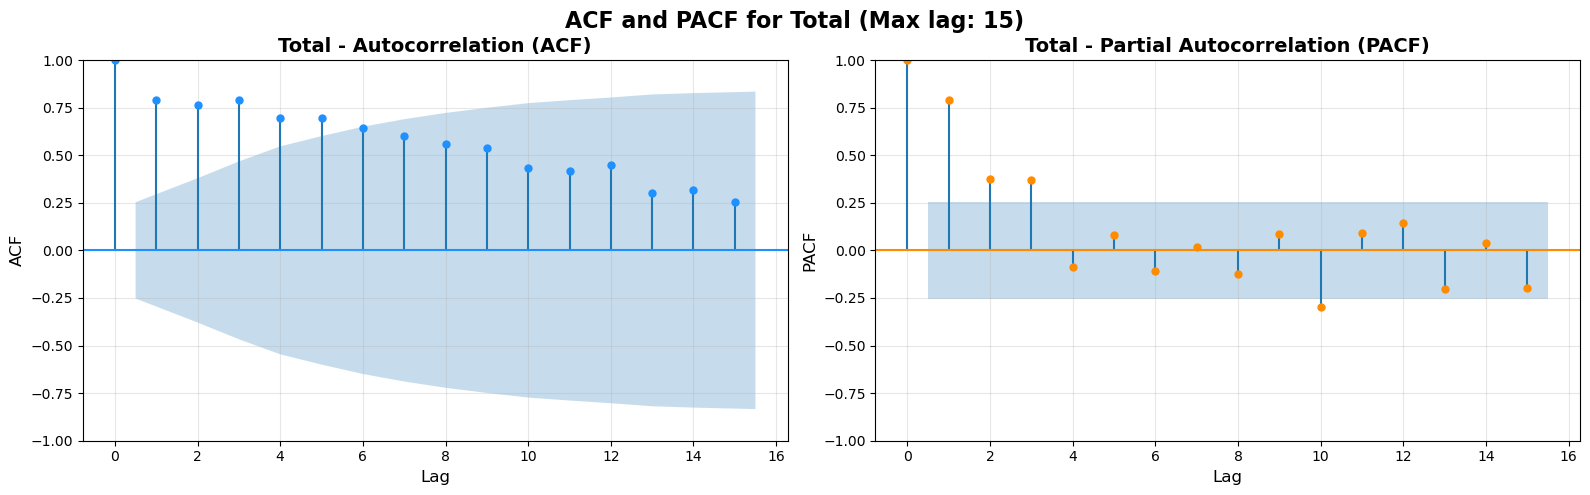

In [27]:
# Calculate appropriate lag for ACF/PACF based on data length
max_lags = min(int(len(df) * 0.25), 24)

# Loop through each drug column
for column in df.columns:
    
    # Create subplots for ACF & PACF
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # ACF
    plot_acf(df[column], ax=axes[0], lags=max_lags, alpha=0.05, color='dodgerblue')
    axes[0].set_title(f'{column} - Autocorrelation (ACF)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Lag', fontsize=12)
    axes[0].set_ylabel('ACF', fontsize=12)
    axes[0].grid(alpha=0.3)

    # PACF
    plot_pacf(df[column], ax=axes[1], lags=max_lags, alpha=0.05, color='darkorange', method='ywm')
    axes[1].set_title(f'{column} - Partial Autocorrelation (PACF)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Lag', fontsize=12)
    axes[1].set_ylabel('PACF', fontsize=12)
    axes[1].grid(alpha=0.3)

    # Overall title
    plt.suptitle(f'ACF and PACF for {column} (Max lag: {max_lags})', fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# Time-series 5-fold validation for SARIMA hyperparameter search

In [15]:
# Define parameter grid
p_list = [0,1,2]
d_list = [0,1]
q_list = [0,1,2]
P_list = [0,1]
D_list = [0,1]
Q_list = [0,1]
m = 12 # seasonality

In [50]:
# Store results for all models
results = []
predictions_list = []

In [51]:
cols = df.iloc[:, :-1].columns
total_cols = len(cols)
total_params = len(p_list) * len(d_list) * len(q_list) * len(P_list) * len(D_list) * len(Q_list)
current = 0

for col_idx, col in enumerate(cols, 1):
    
    # prepare train/test sets
    train = df[col].iloc[:-12]
    test = df[col].iloc[-12:]
    
    # grid search for SARIMA hyperparameters
    for p, d, q, P, D, Q in itertools.product(p_list, d_list, q_list, P_list, D_list, Q_list):
        try:
            # SARIMA parameters
            seasonal_order = (P, D, Q, m)
            order = (p, d, q)
            
            model = SARIMAX(train, 
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            
            model_fit = model.fit(disp=False)
            
            # forecast
            forecast = model_fit.get_forecast(steps=12)
            forecast_mean = forecast.predicted_mean
            
            # metrics
            mape = mean_absolute_percentage_error(test, forecast_mean) * 100
            aic_value = model_fit.aic
            
            # store results
            results.append({
                'drug': col,
                'p_order': p,
                'd_order': d,
                'q_order': q,
                'P_order': P,
                'D_order': D,
                'Q_order': Q,
                'MAPE': mape,
                'AIC': aic_value
            })

            # store actual and predicted values
            predictions_list.append({
                'drug': col,
                'p_order': p,
                'd_order': d,
                'q_order': q,
                'P_order': P,
                'D_order': D,
                'Q_order': Q,
                'actual': test.values,
                'predicted': forecast_mean.values
            })
        
        except Exception as e:
            pass  # optionally print errors
        
        # update progress
        current += 1
        print(f"\rProcessing {col_idx}/{total_cols} columns | Column: {col} | Hyperparams: (p={p},d={d},q={q},P={P},D={D},Q={Q}) | Combo {current}/{total_cols*total_params}", 
              end='', flush=True)

Processing 13/13 columns | Column: Acenocoumarol | Hyperparams: (p=2,d=1,q=2,P=1,D=1,Q=1) | Combo 1872/18726/1872

In [52]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(["drug","MAPE"])
results_df.head()

drug  p_order  d_order  q_order  P_order  D_order  Q_order  \
1829  Acenocoumarol        2        0        0        1        0        1   
1732  Acenocoumarol        0        0        0        1        0        0   
1748  Acenocoumarol        0        0        2        1        0        0   
1853  Acenocoumarol        2        1        0        1        0        1   
1740  Acenocoumarol        0        0        1        1        0        0   

          MAPE          AIC  
1829  2.571115  1095.950828  
1732  2.785208    -8.037382  
1748  2.823796    -4.029218  
1853  2.835535    -9.405473  
1740  2.843192    -6.448393

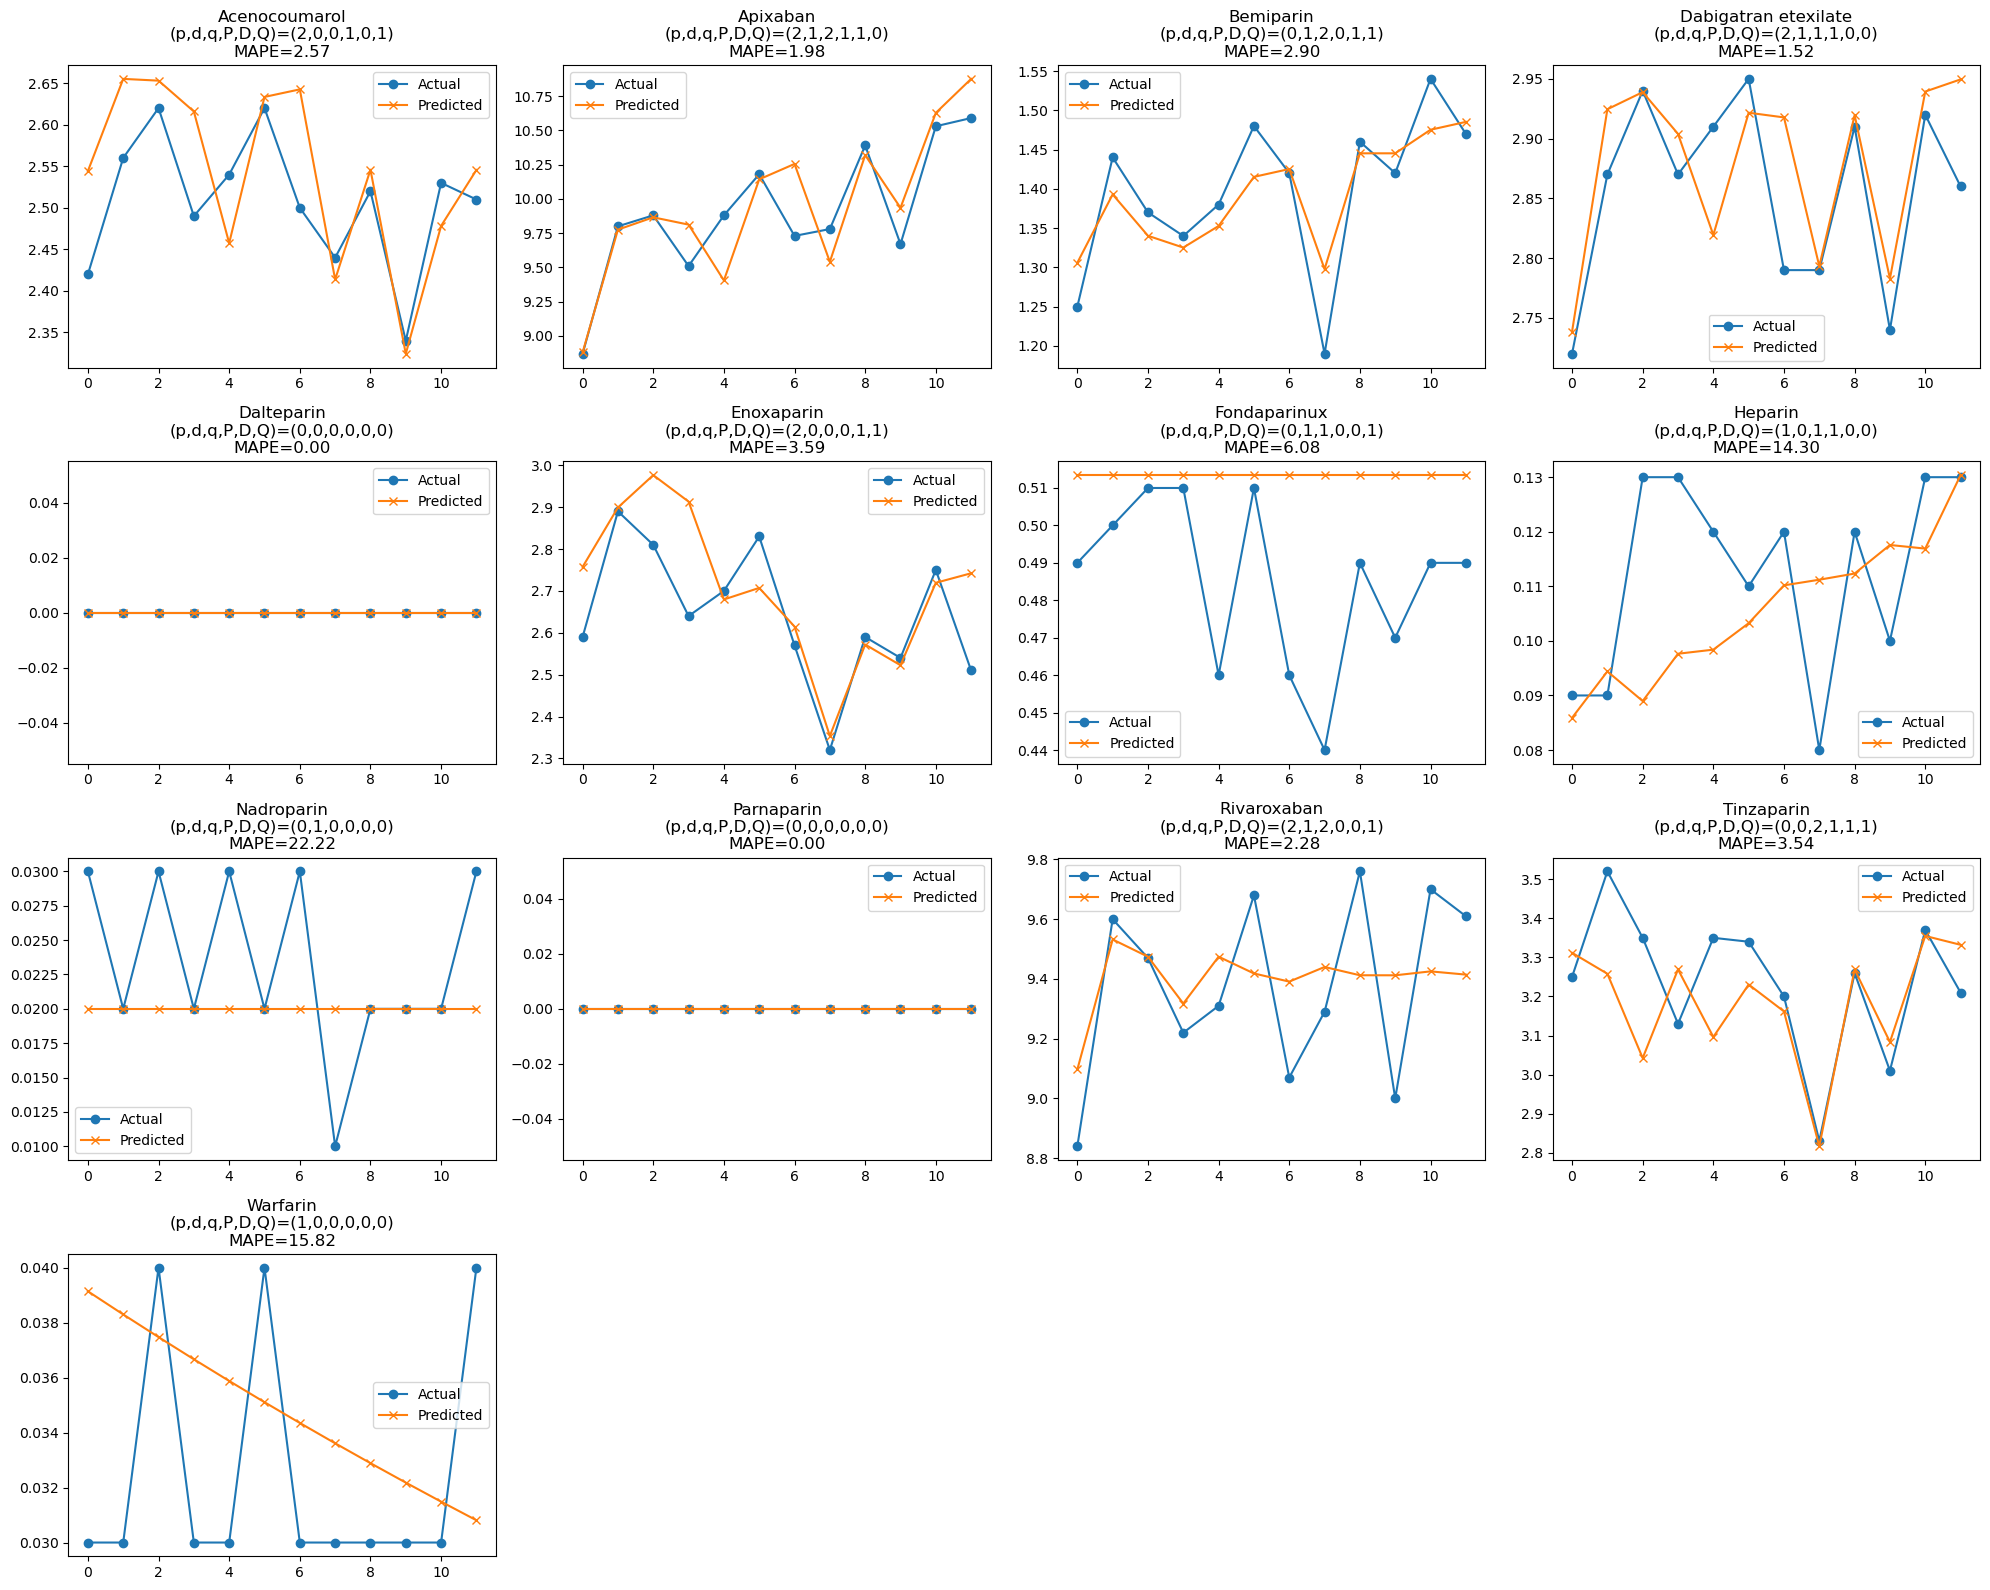

In [53]:
## Plot predicted vs actual values
# Models selected based on lowest MAPE value

# convert results and predictions to DataFrames
results_df = pd.DataFrame(results)
pred_df = pd.DataFrame(predictions_list)

# get best model per column (lowest MAPE)
best_models = results_df.loc[results_df.groupby('drug')['MAPE'].idxmin()]

# set up figure grid (e.g., 4x4 for 13 models)
n_models = len(best_models)
cols_grid = 4
rows_grid = math.ceil(n_models / cols_grid)
fig, axes = plt.subplots(rows_grid, cols_grid, figsize=(cols_grid*5, rows_grid*4), sharey=False)
axes = axes.flatten()

for i, (_, row) in enumerate(best_models.iterrows()):
    drug = row['drug']
    
    # get corresponding predictions
    pred_row = pred_df[
        (pred_df['drug'] == drug) &
        (pred_df['p_order'] == row['p_order']) &
        (pred_df['d_order'] == row['d_order']) &
        (pred_df['q_order'] == row['q_order']) &
        (pred_df['P_order'] == row['P_order']) &
        (pred_df['D_order'] == row['D_order']) &
        (pred_df['Q_order'] == row['Q_order'])
    ].iloc[0]
    
    actual = pred_row['actual']
    predicted = pred_row['predicted']
    
    ax = axes[i]
    ax.plot(actual, label='Actual', marker='o')
    ax.plot(predicted, label='Predicted', marker='x')
    ax.set_title(f"{drug}\n(p,d,q,P,D,Q)=({row['p_order']},{row['d_order']},{row['q_order']},{row['P_order']},{row['D_order']},{row['Q_order']})\nMAPE={row['MAPE']:.2f}")
    ax.legend()
    
# hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

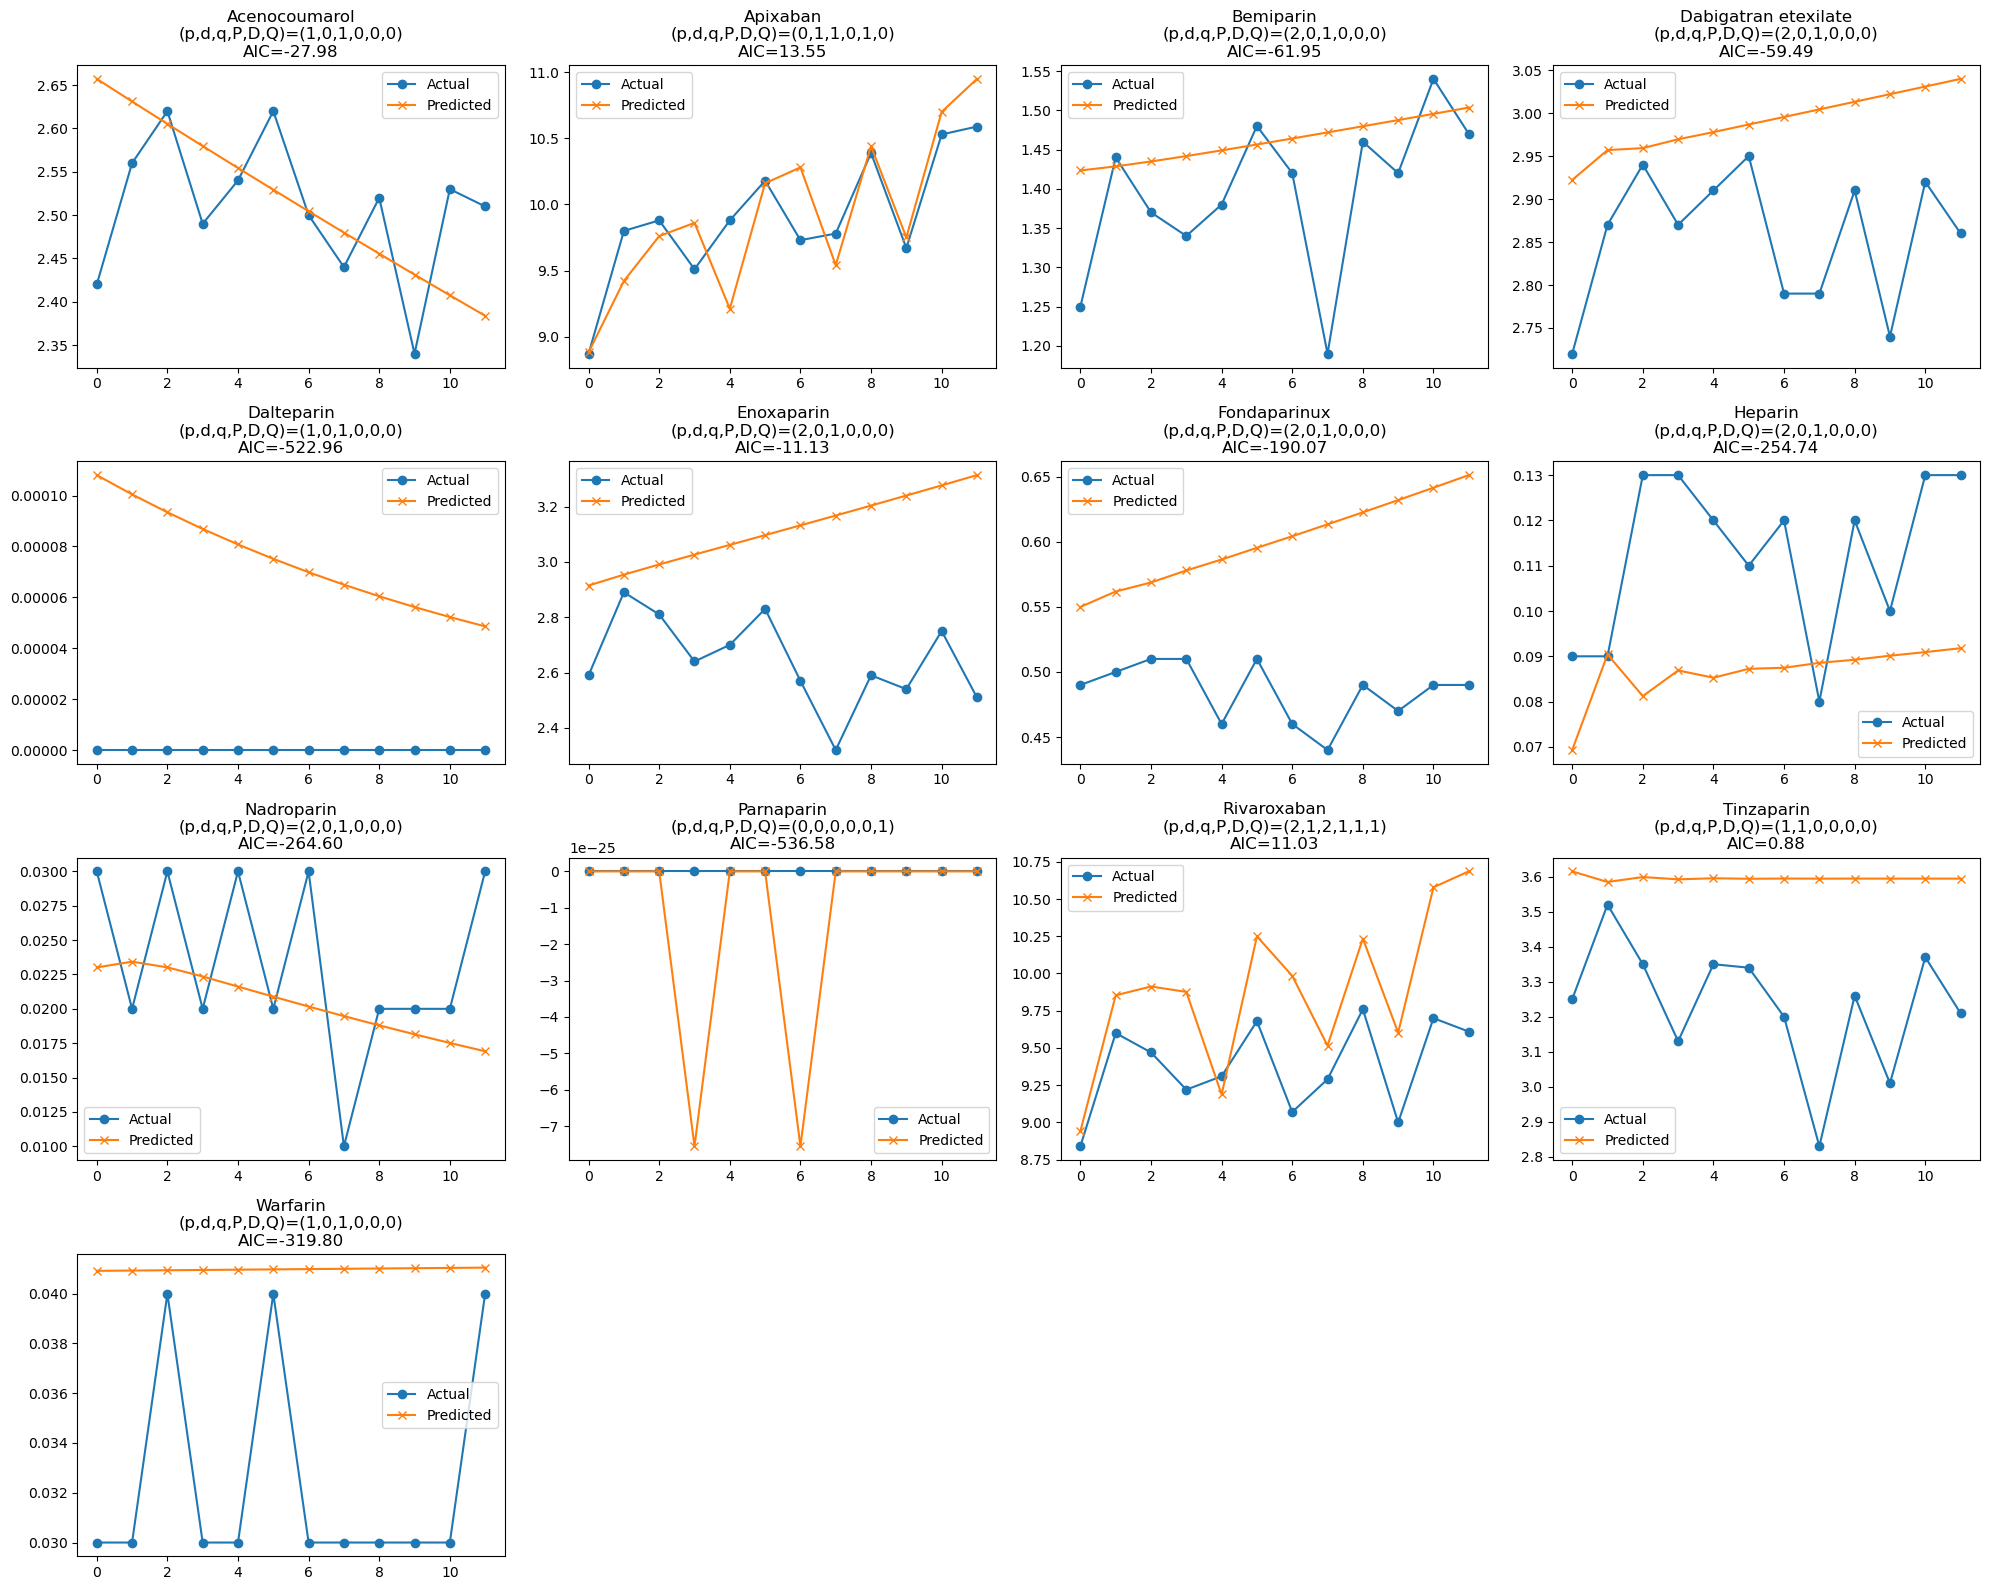

In [54]:
## Plot predicted vs actual values
# Models selected based on lowest AIC value

results_df = pd.DataFrame(results)
pred_df = pd.DataFrame(predictions_list)

# get best model per column (lowest MAPE)
best_models = results_df.loc[results_df.groupby('drug')['AIC'].idxmin()]

# set up figure grid (e.g., 4x4 for 13 models)
n_models = len(best_models)
cols_grid = 4
rows_grid = math.ceil(n_models / cols_grid)
fig, axes = plt.subplots(rows_grid, cols_grid, figsize=(cols_grid*5, rows_grid*4), sharey=False)
axes = axes.flatten()

for i, (_, row) in enumerate(best_models.iterrows()):
    drug = row['drug']
    
    # get corresponding predictions
    pred_row = pred_df[
        (pred_df['drug'] == drug) &
        (pred_df['p_order'] == row['p_order']) &
        (pred_df['d_order'] == row['d_order']) &
        (pred_df['q_order'] == row['q_order']) &
        (pred_df['P_order'] == row['P_order']) &
        (pred_df['D_order'] == row['D_order']) &
        (pred_df['Q_order'] == row['Q_order'])
    ].iloc[0]
    
    actual = pred_row['actual']
    predicted = pred_row['predicted']
    
    ax = axes[i]
    ax.plot(actual, label='Actual', marker='o')
    ax.plot(predicted, label='Predicted', marker='x')
    ax.set_title(f"{drug}\n(p,d,q,P,D,Q)=({row['p_order']},{row['d_order']},{row['q_order']},{row['P_order']},{row['D_order']},{row['Q_order']})\nAIC={row['AIC']:.2f}")
    ax.legend()
    
# hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

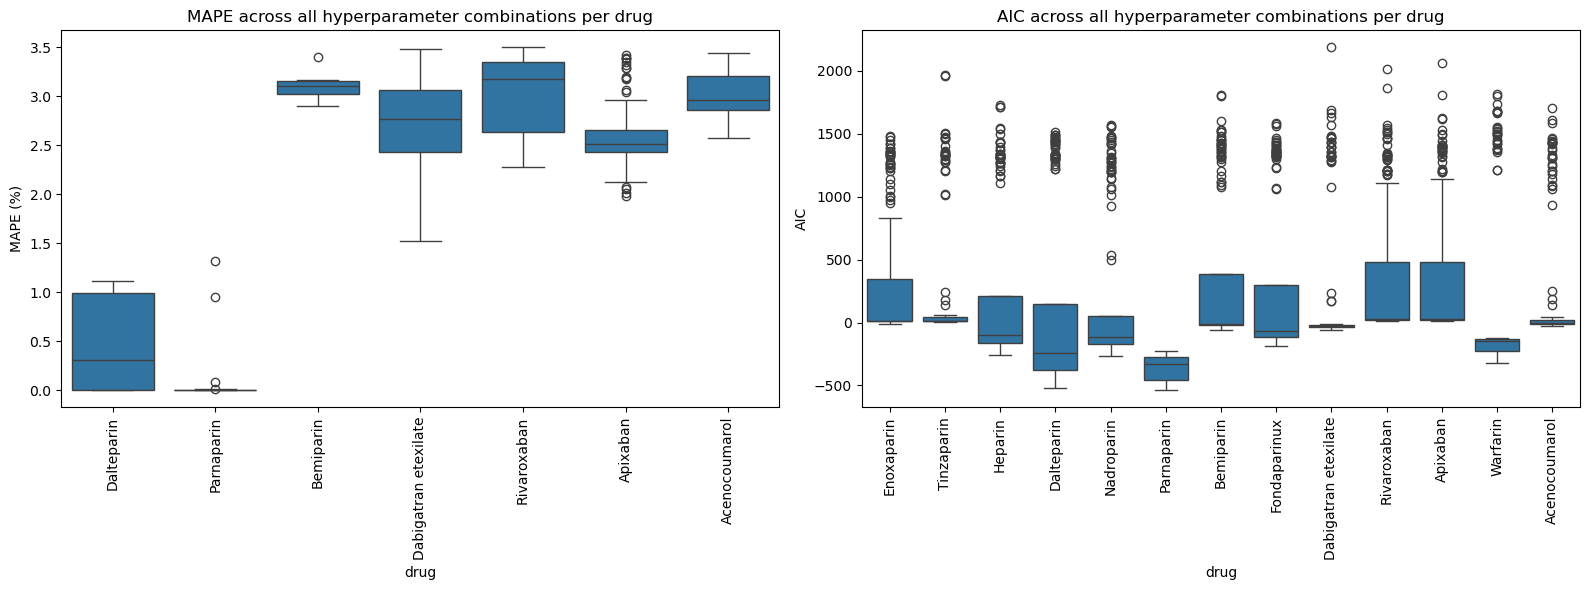

In [57]:
## Plot distribution of MAPE and AIC per combination of hyperparameters
plt.figure(figsize=(16, 6))

# MAPE plot
plt.subplot(1, 2, 1)
# sns.boxplot(x='drug', y='MAPE', data=results_df)
sns.boxplot(x='drug', y='MAPE', data=results_df[results_df['MAPE'] < 3.5])
plt.xticks(rotation=90)
plt.title('MAPE across all hyperparameter combinations per drug')
plt.ylabel('MAPE (%)')

# AIC plot
plt.subplot(1, 2, 2)
sns.boxplot(x='drug', y='AIC', data=results_df)
plt.xticks(rotation=90)
plt.title('AIC across all hyperparameter combinations per drug')
plt.ylabel('AIC')

plt.tight_layout()
plt.show()

# Train final models with best hyperparameters

In [61]:
# Find best hyperparameters per drug (lowest MAPE)
best_models = results_df.loc[results_df.groupby('drug')['MAPE'].idxmin()]
best_models

drug  p_order  d_order  q_order  P_order  D_order  \
1829         Acenocoumarol        2        0        0        1        0   
1582              Apixaban        2        1        2        1        1   
907              Bemiparin        0        1        2        0        1   
1284  Dabigatran etexilate        2        1        1        1        0   
432             Dalteparin        0        0        0        0        0   
99              Enoxaparin        2        0        0        0        1   
1041          Fondaparinux        0        1        1        0        0   
348                Heparin        1        0        1        1        0   
600             Nadroparin        0        1        0        0        0   
720             Parnaparin        0        0        0        0        0   
1433           Rivaroxaban        2        1        2        0        0   
167             Tinzaparin        0        0        2        1        1   
1632              Warfarin        1        0        0        0        0   

      Q_order       MAPE          AIC  
1829        1   2.571115  1095.950828  
1582        0   1.978519    16.936497  
907         1   2.901901   -11.218860  
1284        0   1.522279   -46.163273  
432         0   0.000000  -498.636657  
99          1   3.591166    10.312019  
1041        1   6.083066  1312.965338  
348         0  14.296414  -192.859926  
600         0  22.222222  -253.168640  
720         0   0.000000  -385.590217  
1433        1   2.279180  1498.110806  
167         1   3.539076    29.223602  
1632        0  15.820767  -302.346065

In [81]:
# Dictionary to store future forecasts
future_forecasts = {}

In [82]:
# Forecast horizon: 8 years (8*12 = 96 months)
forecast_steps = 8 * 12

In [83]:
for idx, (_, row) in enumerate(best_models.iterrows(), 1):
    drug = row['drug']
    p, d, q = row['p_order'], row['d_order'], row['q_order']
    P, D, Q = row['P_order'], row['D_order'], row['Q_order']
    
    train = df[drug]
    
    try:
        model = SARIMAX(
            train,
            order=(p, d, q),
            seasonal_order=(P, D, Q, m),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)
        
        forecast_res = model_fit.get_forecast(steps=forecast_steps)
        forecast_mean = forecast_res.predicted_mean
        ci = forecast_res.conf_int(alpha=0.05)  # 95% confidence interval
        
        # save in a DataFrame
        future_forecasts[drug] = pd.DataFrame({
            'forecast': forecast_mean.values,
            'ci_lower': ci.iloc[:, 0].values,
            'ci_upper': ci.iloc[:, 1].values
        }, index=pd.date_range(start=train.index[-1] + pd.offsets.MonthBegin(1),
                               periods=forecast_steps, freq='MS'))
    
    except Exception as e:
        print(f"\nError training {drug}: {e}")
        future_forecasts[drug] = pd.DataFrame({
            'forecast': [np.nan]*forecast_steps,
            'ci_lower': [np.nan]*forecast_steps,
            'ci_upper': [np.nan]*forecast_steps
        }, index=pd.date_range(start=train.index[-1] + pd.offsets.MonthBegin(1),
                               periods=forecast_steps, freq='MS'))
    
    # progress display
    print(f"\rForecasting {idx}/{len(best_models)} drugs", end='', flush=True)

Forecasting 13/13 drugs

In [86]:
# Combine forecasts into a single DataFrame
all_forecasts = []

for drug, df_forecast in future_forecasts.items():
    temp = df_forecast.copy()
    temp['drug'] = drug
    temp['date'] = temp.index
    all_forecasts.append(temp)

# concatenate all drugs
future_df = pd.concat(all_forecasts, axis=0)

# reorder columns
future_df = future_df[['drug', 'date', 'forecast', 'ci_lower', 'ci_upper']]

In [87]:
future_df.head()

drug       date  forecast  ci_lower  ci_upper
2023-01-01  Acenocoumarol 2023-01-01  2.287174  2.014086  2.560262
2023-02-01  Acenocoumarol 2023-02-01  2.328482  2.055382  2.601581
2023-03-01  Acenocoumarol 2023-03-01  2.421850  2.153914  2.689786
2023-04-01  Acenocoumarol 2023-04-01  2.272157  2.004221  2.540093
2023-05-01  Acenocoumarol 2023-05-01  2.198208  1.930285  2.466130

# Plot historical data with future predictions

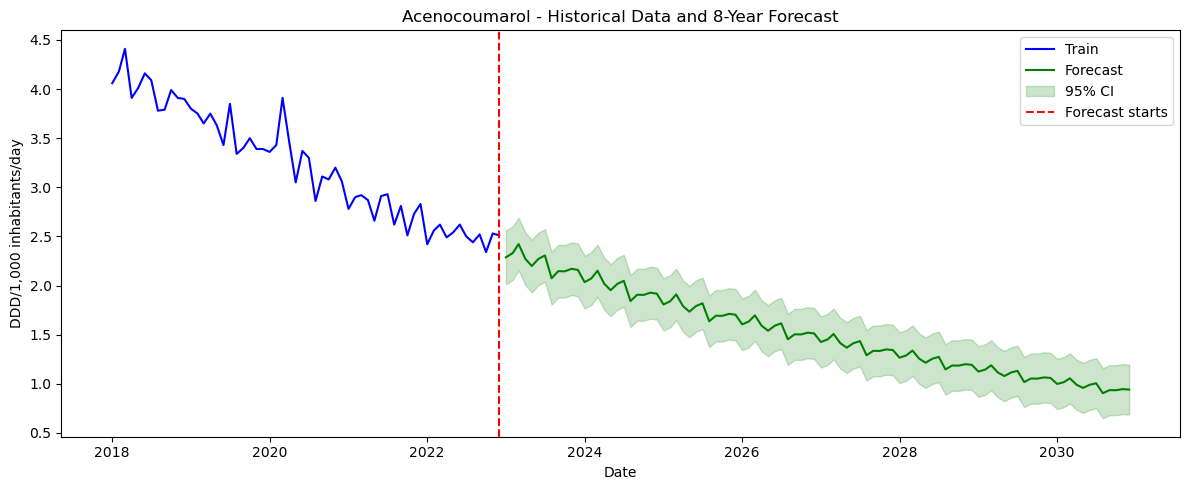

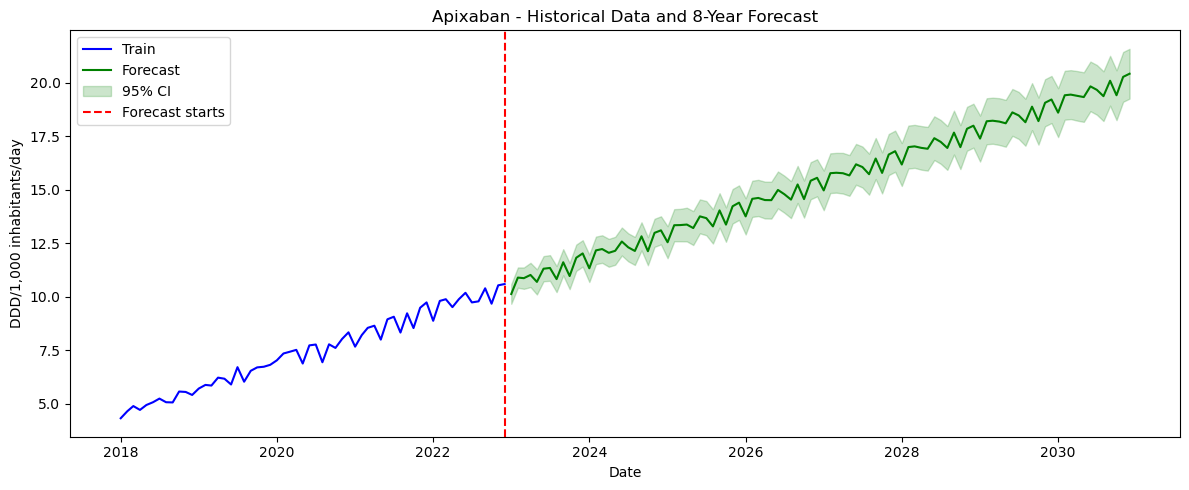

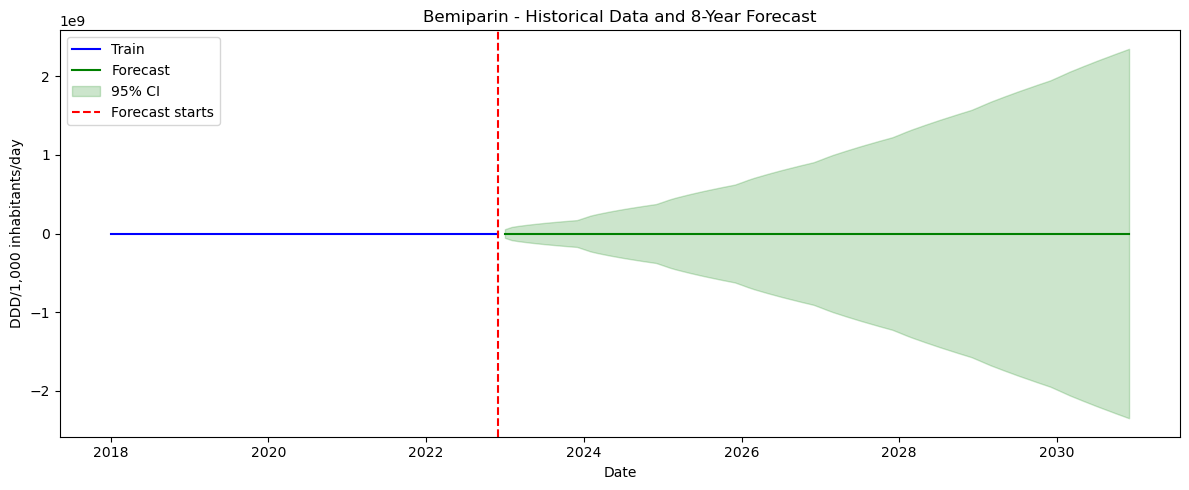

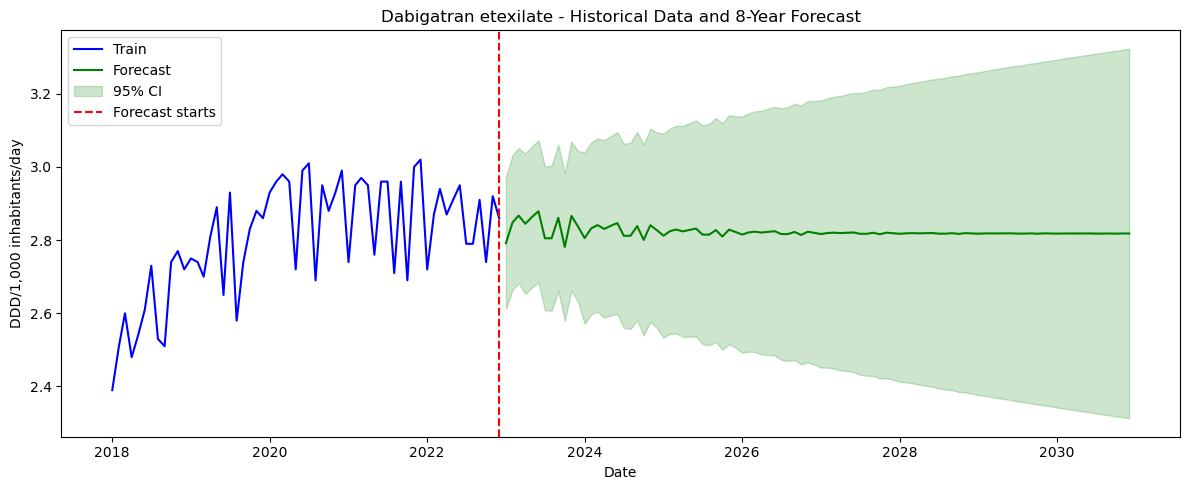

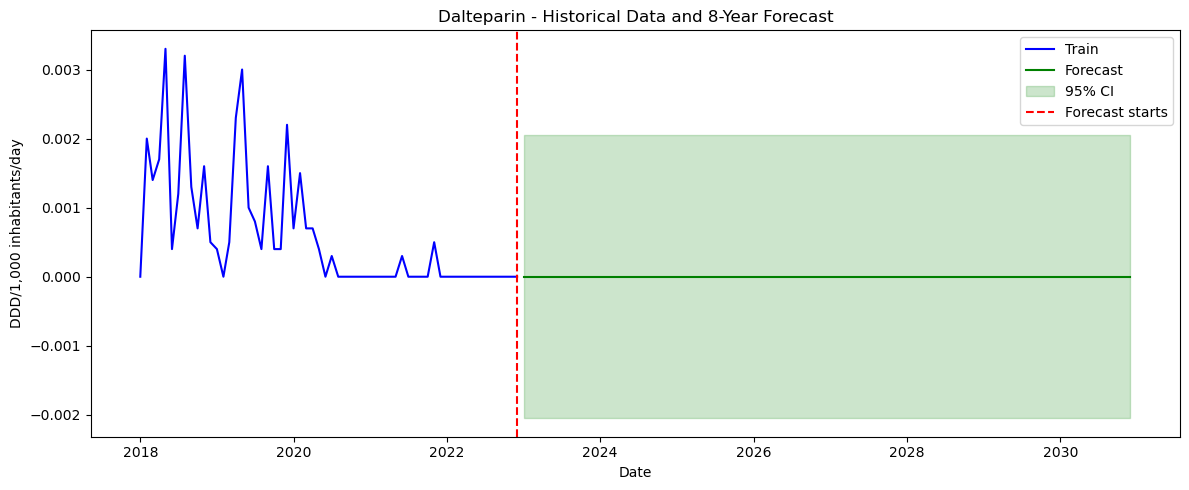

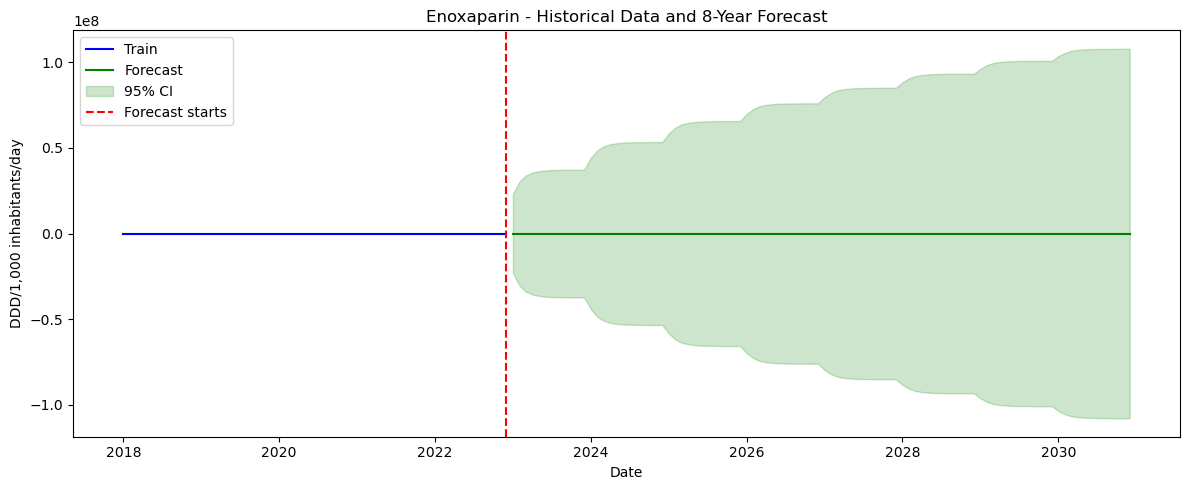

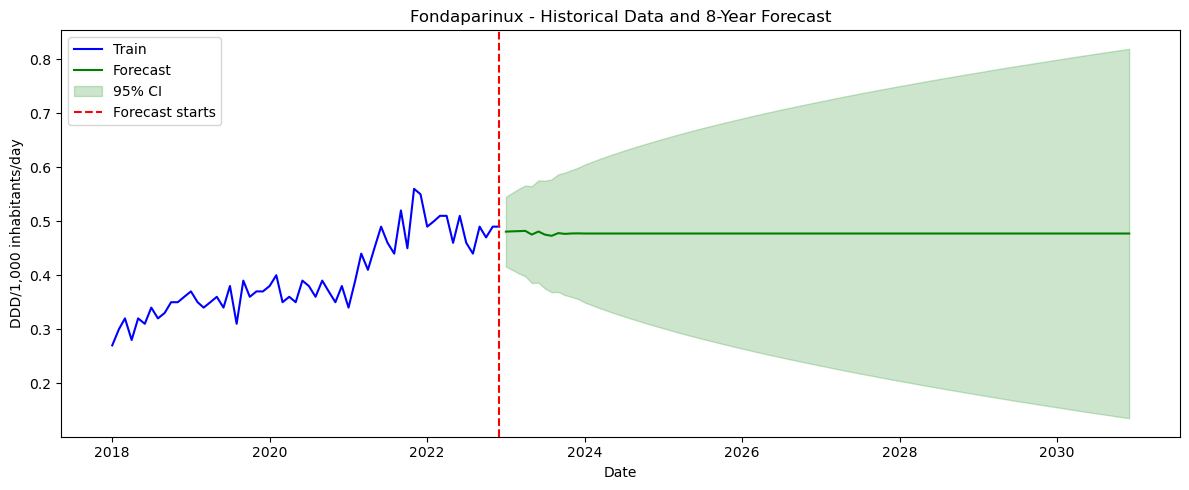

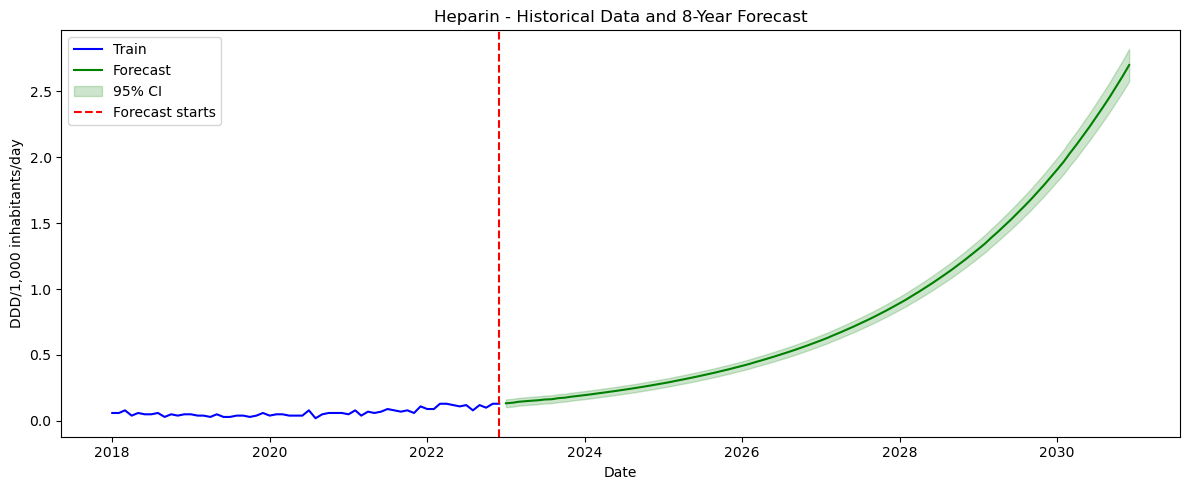

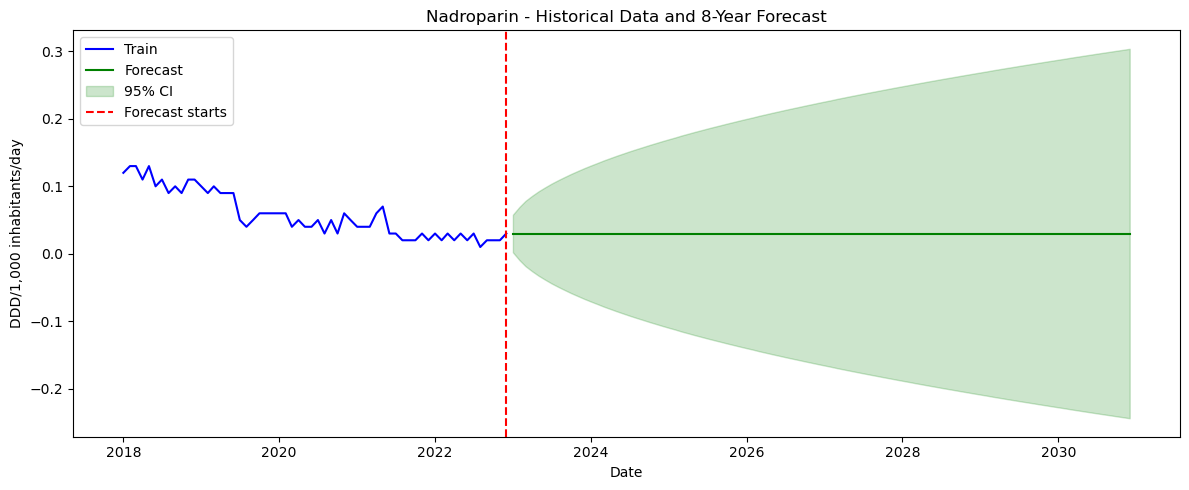

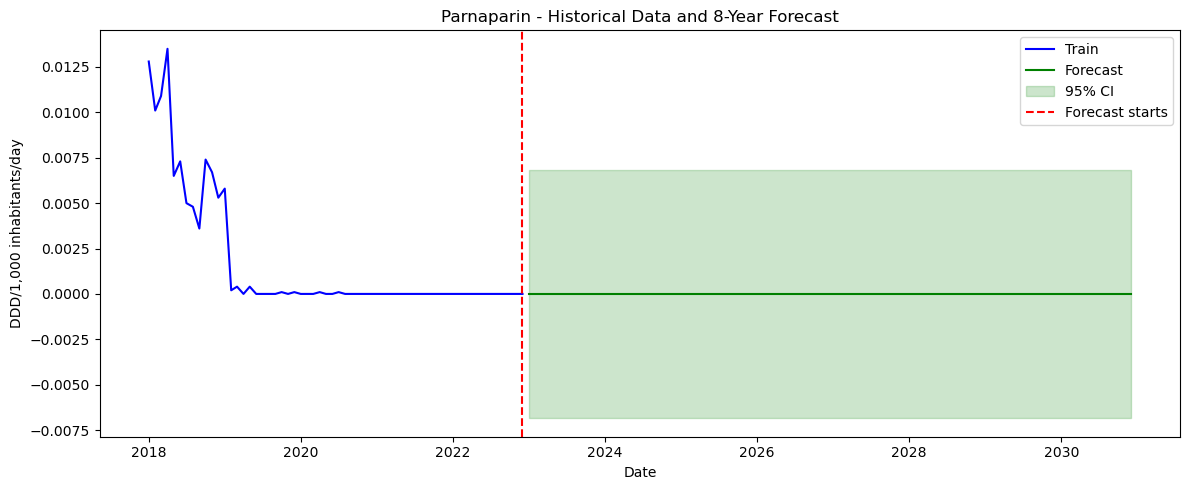

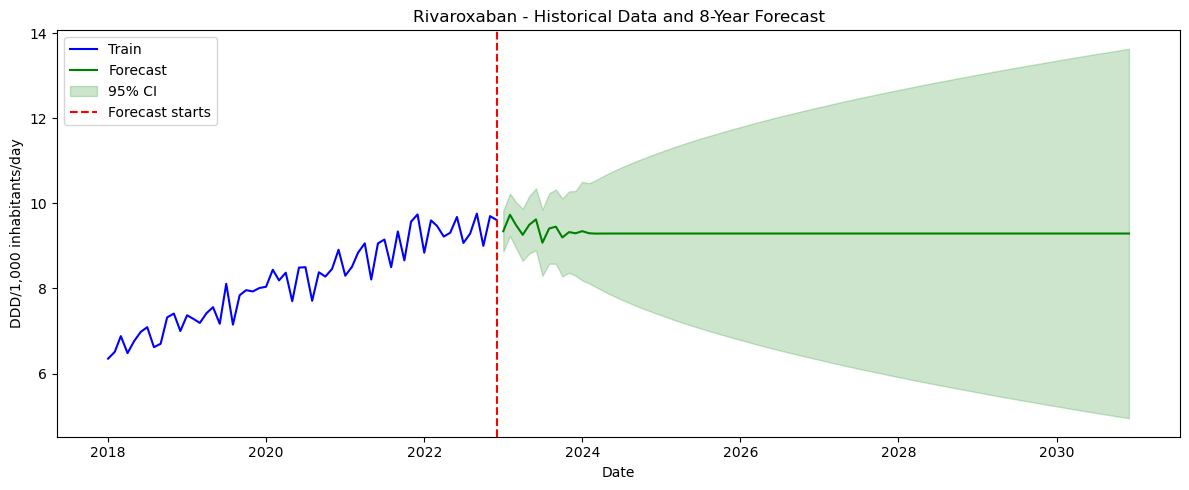

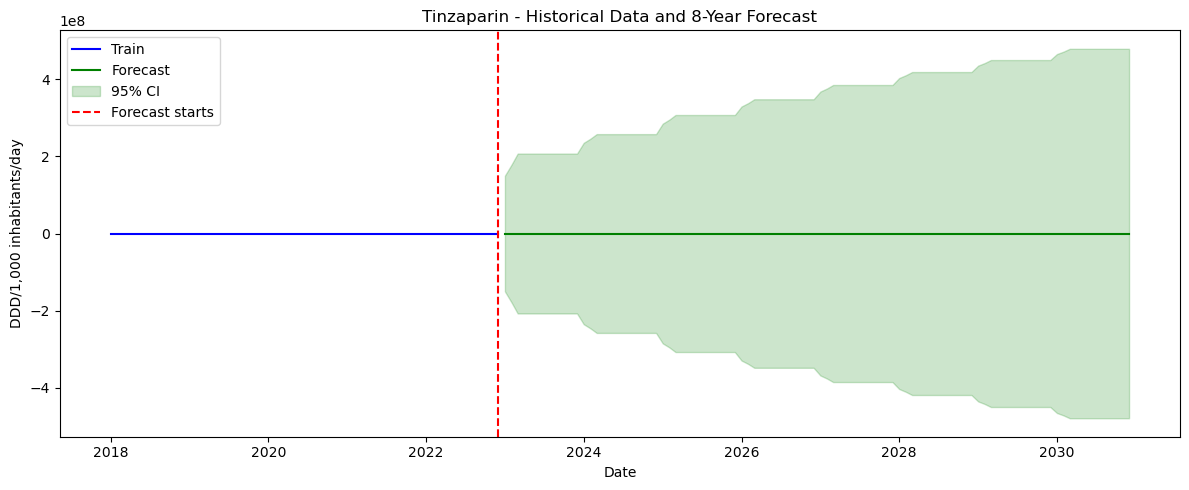

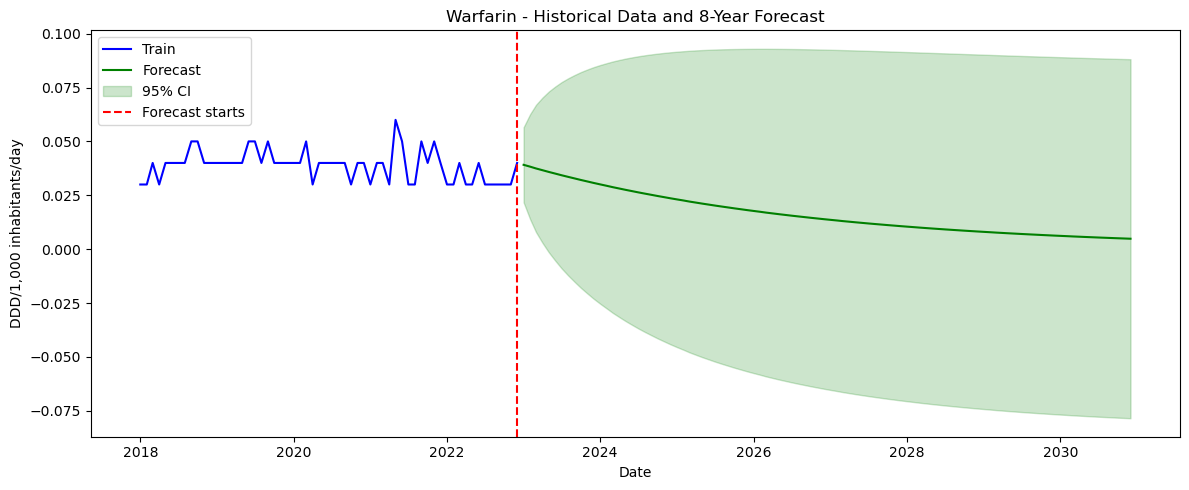

In [88]:
forecast_steps = 8 * 12  # 8 years

for drug, df_forecast in future_forecasts.items():
    
    train = df[drug]
    
    # Forecast values and confidence intervals
    forecast_values = df_forecast['forecast'].values
    ci_lower = df_forecast['ci_lower'].values
    ci_upper = df_forecast['ci_upper'].values
    forecast_index = df_forecast.index

    # Plot
    plt.figure(figsize=(12,5))
    # Plot train data
    plt.plot(train.index, train.values, color='blue', label='Train')
    # Plot forecast
    plt.plot(forecast_index, forecast_values, color='green', linestyle='-', label='Forecast')
    # Shade 95% confidence interval
    plt.fill_between(forecast_index, ci_lower, ci_upper, color='green', alpha=0.2, label='95% CI')
    # Vertical line separating train and forecast
    plt.axvline(x=train.index[-1], color='red', linestyle='--', label='Forecast starts')
    plt.title(f"{drug} - Historical Data and 8-Year Forecast")
    plt.xlabel("Date")
    plt.ylabel("DDD/1,000 inhabitants/day")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Save results

In [89]:
# hyperparameter tuning results
results_df.to_csv("sarima_hyperparameter_results.csv", index=False)

In [90]:
# Combine forecasts into a single DataFrame for all drugs
all_forecasts = []

for drug, df_forecast in future_forecasts.items():
    temp = df_forecast.copy()
    temp['drug'] = drug
    temp['date'] = temp.index
    all_forecasts.append(temp)

# Concatenate all drugs
future_df = pd.concat(all_forecasts, axis=0)
future_df = future_df[['drug', 'date', 'forecast', 'ci_lower', 'ci_upper']]

# Save to CSV
future_df.to_csv("sarima_future_forecasts_with_CI.csv", index=False)

# Libraries used and version

In [7]:
import pkg_resources

for dist in pkg_resources.working_set:
    print(f"{dist.key}=={dist.version}")

pyside6==6.9.2
asttokens==3.0.0
comm==0.2.3
contourpy==1.3.3
cycler==0.12.1
debugpy==1.8.16
decorator==5.2.1
et-xmlfile==2.0.0
exceptiongroup==1.3.0
executing==2.2.1
fonttools==4.59.2
importlib-metadata==8.7.0
ipykernel==6.30.1
ipython==9.5.0
ipython-pygments-lexers==1.1.1
jedi==0.19.2
joblib==1.5.2
jupyter-client==8.6.3
jupyter-core==5.8.1
kiwisolver==1.4.9
matplotlib==3.10.6
matplotlib-inline==0.1.7
munkres==1.1.4
nest-asyncio==1.6.0
numpy==2.3.3
openpyxl==3.1.5
packaging==25.0
pandas==2.2.2
parso==0.8.5
patsy==1.0.1
pexpect==4.9.0
pickleshare==0.7.5
pillow==11.3.0
pip==25.2
platformdirs==4.4.0
prompt-toolkit==3.0.52
psutil==7.0.0
ptyprocess==0.7.0
pure-eval==0.2.3
pygments==2.19.2
pyparsing==3.2.3
python-dateutil==2.9.0.post0
pytz==2025.2
pyzmq==27.1.0
scikit-learn==1.7.2
scipy==1.16.1
seaborn==0.13.2
setuptools==80.9.0
shiboken6==6.9.2
six==1.17.0
stack-data==0.6.3
statsmodels==0.14.5
threadpoolctl==3.6.0
tornado==6.5.2
tqdm==4.67.1
traitlets==5.14.3
typing-extensions==4.15.0
tzdat